In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import io
import sys
import ast
sys.path.append(os.path.join(os.getcwd(), '..','..'))
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from mlpremier.cnn.preprocess import generate_cnn_data, split_preprocess_cnn_data, preprocess_cnn_data
from mlpremier.cnn.model import build_train_cnn, full_cnn_pipeline
from mlpremier.cnn.evaluate import gridsearch_analysis
import tensorflow as tf
import random
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


from config import STANDARD_CAT_FEATURES, STANDARD_NUM_FEATURES, NUM_FEATURES_DICT


# Run Full Training

======= Generating CNN Data for Season: ['2020-21', '2021-22'], Position: GK =======
Dropping Players with Avg. Playtime < 1e-06...

Total players of type GK = 163.
82 players dropped due to low average playtime.
Generated windowed dataframe for CNN of shape: (2502, 7).
Generated combined features dataframe for preprocessing of shape: (2988, 11).

========== EDA ==========
Selected Statistics:
      total_points  ict_index  clean_sheets  goals_conceded        bps  \
mean      1.871821   1.175234      0.145917        0.701138   9.402945   
min      -2.000000   0.000000      0.000000        0.000000   0.000000   
max      15.000000   8.100000      1.000000        9.000000  51.000000   
std       2.732090   1.536084      0.353082        1.149972  10.620628   

      matchup_difficulty  goals_scored   assists  yellow_cards  red_cards  
mean           -0.032798      0.000335  0.001673      0.022423   0.000669  
min            -3.000000      0.000000  0.000000      0.000000   0.000000  
max 

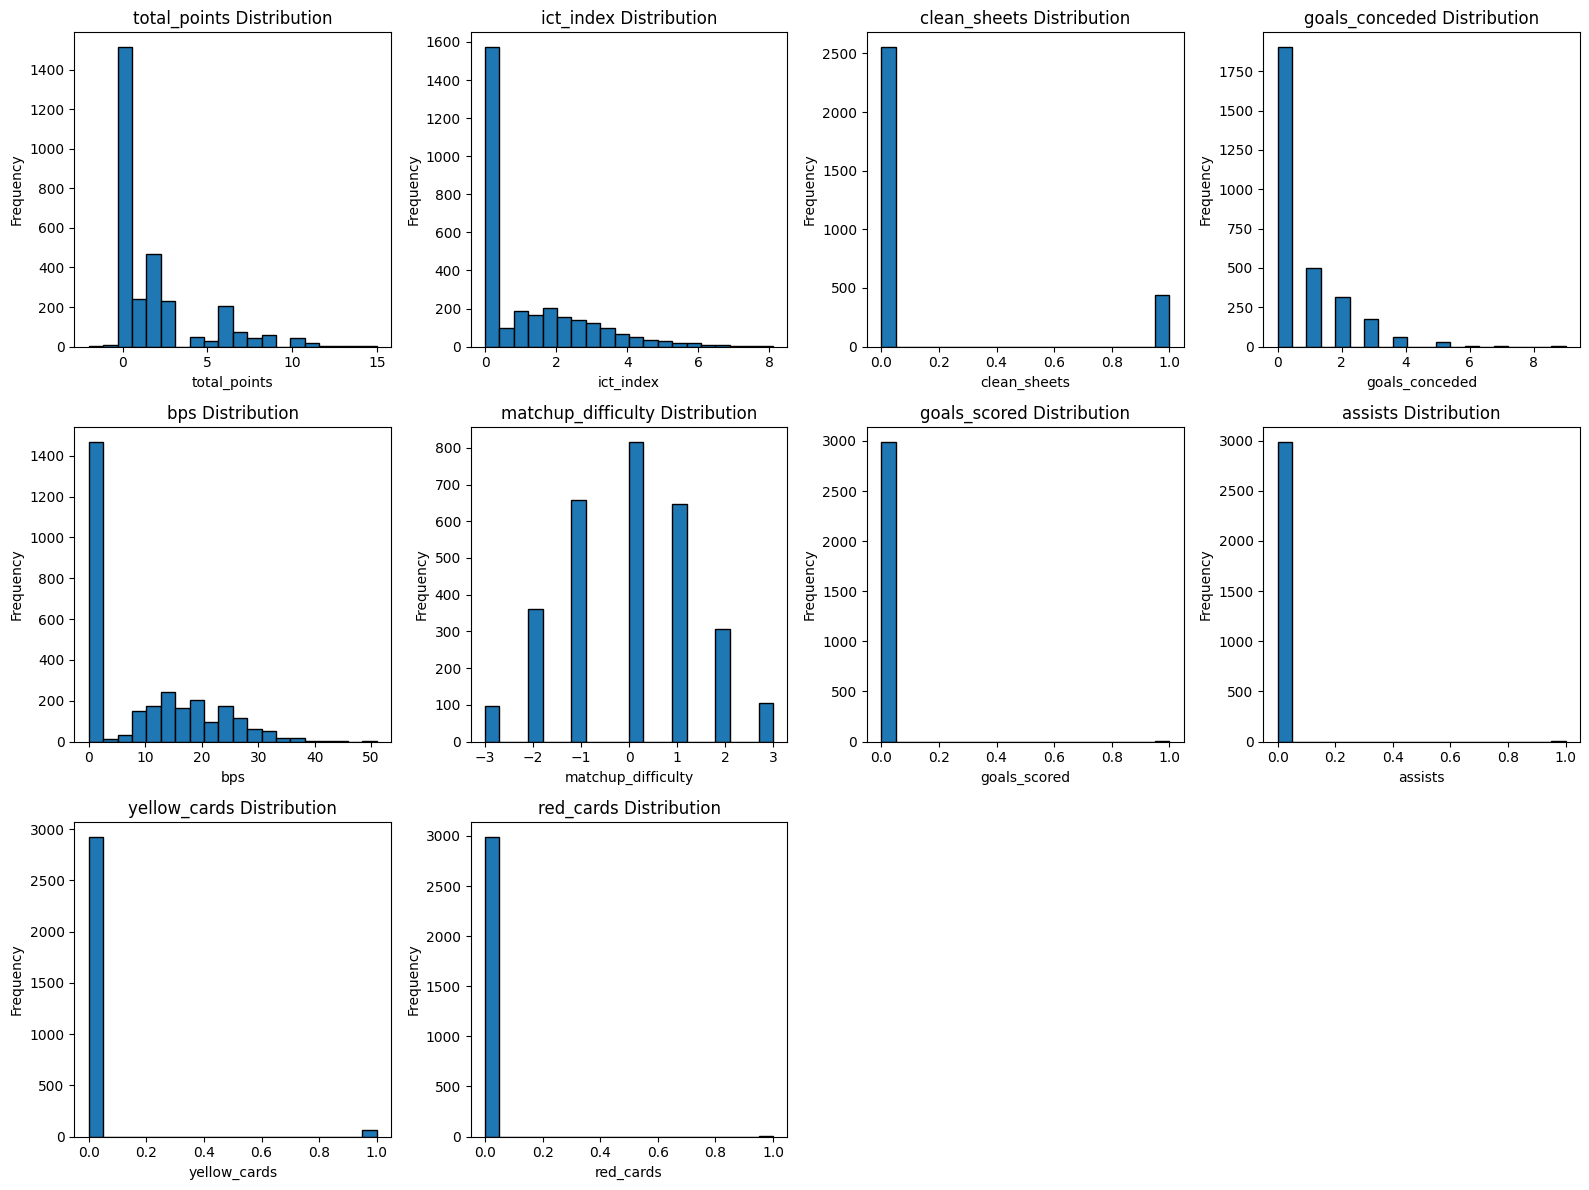

========== Done Generating CNN Data ==========

========== Splitting CNN Data ==========

=== Stratifying Split by : Stdev ===
Shape of windowed_df: (2502, 7)
Shape of a given window (prior to preprocessing): (6, 11)
stdev Distribution of Players:



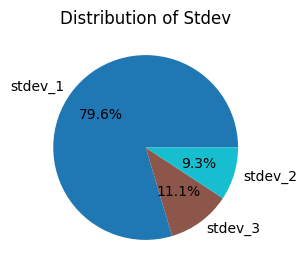

========== Preprocessing CNN Data ==========

Mean of Standard Scaler:
[ 1.94211124e+00  1.28342792e+00  1.45289444e-01  7.49148695e-01
  9.96594779e+00 -1.87854711e-01  0.00000000e+00  1.70261067e-03
  2.66742338e-02  1.13507378e-03]

Standard Deviation of Standard Scaler:
[ 2.73976222  1.60627602  0.35239243  1.15661345 10.75598603  1.34612153
  1.          0.04122756  0.16112951  0.03367173]
Transforming features using StandardScaler + OHE Pipeline.
========== Done Preprocessing CNN Data ==========

========== Done Splitting CNN Data ==========

====== Building CNN Architecture ======
====== Done Building CNN Architecture ======
Epoch 84: early stopping
13/13 [==============================] - 0s 393us/step


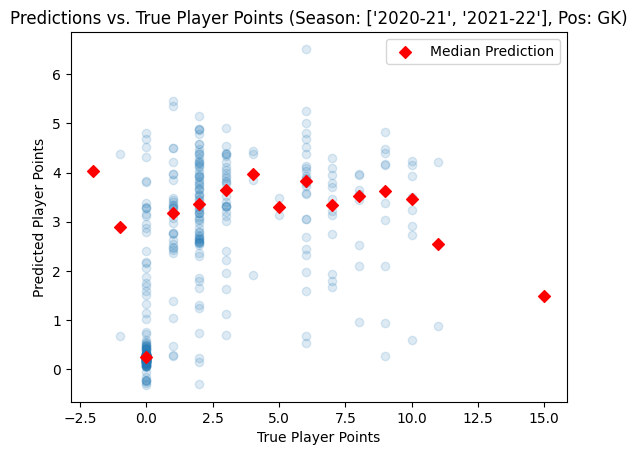

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 6.950896739959717, Test Mean Absolute Error (MAE): 1.6599262952804565, Test Spearman Correlation: 0.6653748750686646


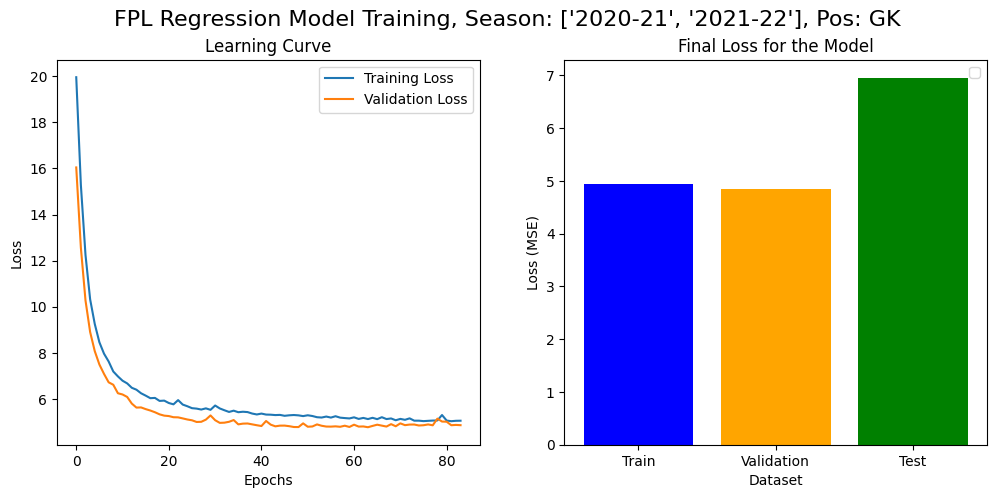

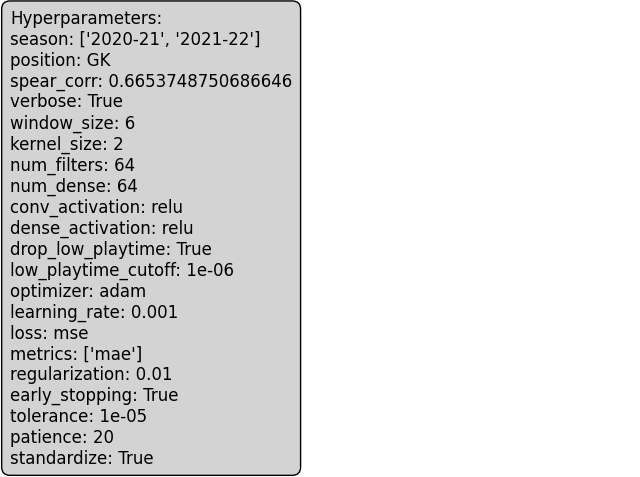

(<keras.src.engine.functional.Functional at 0x2c0bbc160>,
 {'season': ['2020-21', '2021-22'],
  'position': 'GK',
  'train_mse': 4.950965404510498,
  'train_mae': 1.3734174966812134,
  'val_mse': 4.856905460357666,
  'val_mae': 1.345048189163208,
  'test_mse': 6.950896739959717,
  'test_mae': 1.6599262952804565,
  'spear_corr': <tf.Tensor: shape=(), dtype=float32, numpy=0.6653749>,
  'verbose': True,
  'window_size': 6,
  'kernel_size': 2,
  'num_filters': 64,
  'num_dense': 64,
  'conv_activation': 'relu',
  'dense_activation': 'relu',
  'drop_low_playtime': True,
  'low_playtime_cutoff': 1e-06,
  'optimizer': 'adam',
  'learning_rate': 0.001,
  'loss': 'mse',
  'metrics': ['mae'],
  'regularization': 0.01,
  'early_stopping': True,
  'tolerance': 1e-05,
  'patience': 20,
  'standardize': True})

In [3]:
SEED = 229

random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = os.path.join(os.getcwd(), '..', 'data', 'clean_data')

full_cnn_pipeline(DATA_DIR,
                season = ['2020-21', '2021-22'], 
                position = 'GK', 
                window_size=6,
                kernel_size=2,
                num_filters=64,
                num_dense=64,
                batch_size = 32,
                epochs = 1000,  
                drop_low_playtime = True,
                low_playtime_cutoff = 1e-6,
                num_features = ['total_points', 'ict_index', 'clean_sheets', 'goals_conceded', 'bps', 'matchup_difficulty', 'goals_scored', 'assists', 'yellow_cards', 'red_cards'],
                cat_features = STANDARD_CAT_FEATURES, 
                stratify_by = 'stdev', 
                conv_activation = 'relu',
                dense_activation = 'relu',
                optimizer='adam',
                learning_rate= 0.001,  
                loss = 'mse',
                metrics = ['mae'],
                verbose = True,
                regularization = 0.01, 
                early_stopping = True, 
                tolerance = 1e-5, # only used if early stopping is turned on, threshold to define low val loss decrease
                patience = 20,   # num of iterations before early stopping bc of low val loss decrease
                plot = True, 
                draw_model = False,
                standardize= True,)

# GridSearch for Best Model

In [4]:
from mlpremier.cnn.experiment import gridsearch_cnn

#gridsearch_cnn(epochs=100, verbose=False)

#PERFORMING VIA COMMAND LINE SCRIPT NOW FOR EFFICIENCY

## Investigate GridSearch Results

## Learning Curve, Filter Investigation

In [5]:
def investigate_model_v0(expt_name: str = 'gridsearch', 
                      drop_low_playtime: bool = True,
                      **kwargs):
    """
    Investigate the best model for the given experiment and drop status.

    Retrains the model on the same exact data split (to avoid data leakage), and
    generates learning curves.
    """
    season =  "['2020-21', '2021-22']"
    best_params = gridsearch_analysis(expt_name, 
                        season=season, 
                        eval_top=1,
                        drop_low_playtime=drop_low_playtime,
                        **kwargs)
    
    POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
    best_models = {}
    for position in POSITIONS: 

        print(f"\n======= Retraining and Filter Analysis for {position} model: =======\n")
        # Clean up and consolidate parameters in the 'params' dictionary
        params = best_params.loc[position, :].to_dict()

        serialized_dataset = params.pop('dataset')
        dataset = pickle.loads(ast.literal_eval(serialized_dataset))

        # Retrieve individual datasets
        X_train = dataset['X_train']
        d_train = dataset['d_train']
        y_train = dataset['y_train']
        X_val = dataset['X_val']
        d_val = dataset['d_val']
        y_val = dataset['y_val']
        X_test = dataset['X_test']
        d_test = dataset['d_test']
        y_test = dataset['y_test']

        serialized_pipeline = params.pop('pipeline')
        pipeline = pickle.loads(ast.literal_eval(serialized_pipeline))

        params['season'] = ['2020-21', '2021-22']
        params['metrics'] = ['mae']
        params['num_features'] = NUM_FEATURES_DICT[params['position']][params.pop('amt_num_features')]
        params.pop('stratify_by')  #don't need this, we have the pickled split data 

        # Add the datasets to params
        params.update({
            'X_train': X_train,
            'd_train': d_train,
            'y_train': y_train,
            'X_val': X_val,
            'd_val': d_val,
            'y_val': y_val,
            'X_test': X_test,
            'd_test': d_test,
            'y_test': y_test,
            'plot': True,
        })

        # =========== Qualitative Analysis of Best & Worst Ex =============

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        model, expt_res = build_train_cnn(**params)
        best_models[position] = model

        y_pred = model.predict([X_test, d_test])
        y_test_flattened = y_test.flatten()
        y_pred_flattened = y_pred.flatten()
        mse_per_example = np.square(y_test_flattened - y_pred_flattened)

        results_df = pd.DataFrame({'Actual Score': y_test_flattened, 'Predicted Score': y_pred_flattened, 'MSE': mse_per_example})
        results_df['d_test'] = d_test

        # Add X_test features to the DataFrame
        # unstandardize the features
        X_test_original = X_test.copy()

        # Calculate unstandardized pts
        numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']
        X_test_reshaped = X_test_original.reshape(-1, X_test_original.shape[-1])
        X_test_unstandardized = numerical_transformer.inverse_transform(X_test_reshaped).astype(int)
        X_test_unstandardized = X_test_unstandardized.reshape(X_test_original.shape)
        X_test_unstandardized_2d = X_test_unstandardized.reshape(X_test_unstandardized.shape[0], -1)
        column_names = [f'pts_week{i}' for i in range(X_test_unstandardized.shape[1])]
        unstandardized_df = pd.DataFrame(X_test_unstandardized_2d, columns=column_names)

        results_df = pd.concat([results_df, unstandardized_df], axis=1)

        results_df.sort_values(by='MSE', ascending=False, inplace=True)

        print(f"\nWorst two examples for {position}:\n")
        display(results_df.head(2))

        print(f"\nBest two examples for {position}:\n")
        display(results_df.tail(2))


        for layer in model.layers:
            if 'conv' not in layer.name:
                continue
            filters, biases = layer.get_weights()

        # retrieve filter weights from the second hidden layer
        filters, biases = model.layers[1].get_weights()

        # normalize filter values by z-score normalization
        mean_value, std_dev = filters.mean(), filters.std()
        normalized_filters = (filters - mean_value) / std_dev
        mean_filter = normalized_filters.mean(axis=-1)

        # set greyscale color map
        cmap = plt.cm.Greys_r
        cmap.set_bad('0.5')  # Set the color for NaN values (if any) to medium-grey

        # plot the normalized average filter with numeric values inside pixels
        fig, ax = plt.subplots()
        img = ax.imshow(mean_filter, cmap=cmap, vmin=-1, vmax=1)

        # add text annotations with normalized values inside each pixel
        for i, value in enumerate(mean_filter):
            value = value[0]
            # set text color based on brightness
            text_color = 'white' if value < 0 else 'black'
            ax.text(0, i, f"{value:.4f}", ha='center', va='center', fontsize=8, color=text_color)
        ax.set_title("Averaged 1D Convolution Filter (Normalized)")
        ax.axis('off')
        plt.show()

    return best_models


## V11 (stratified by stdev score)

### Drop Model

In [6]:
# model with drop benched players
best_models = investigate_model('gridsearch_v11', drop_low_playtime=True, stratify_by='stdev')

NameError: name 'investigate_model' is not defined

### Easy Model (Full Data)

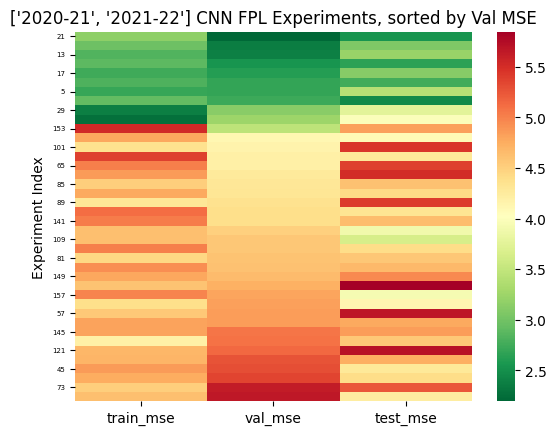


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           4          64   
DEF  ['2020-21', '2021-22']      DEF           9           1          64   
MID  ['2020-21', '2021-22']      MID           6           3          64   
FWD  ['2020-21', '2021-22']      FWD           9           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK        20        True          ptsonly   
DEF       20        True          ptsonly   
MID       20        True          ptsonly   
FWD       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       stdev  
DEF  b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       stdev  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       stdev  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       stdev  

[4 rows x 23 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.151635  2.195067  2.542064   0.943851  0.704563  0.807096
DEF   5.008407  4.201867  5.381500   1.307318  1.117430  1.310278
MID   4.778931  4.118160  4.081420   1.215706  1.185421  1.183330
FWD   5.526993  3.454245  4.822538   1.390139  0.998145  1.222424


Average Val MSE:
3.4923346042633057

Average Test MSE:
4.206880748271942

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (2846, 6, 1)
X_val shape: (1150, 6, 1)
X_test shape: (703, 6, 1)
Epoch 144: early stopping
22/22 [==============================] - 0s 339us/step


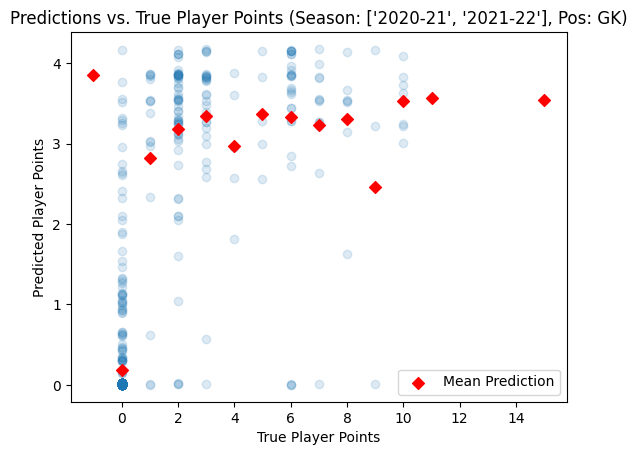

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 2.4974353313446045, Test Mean Absolute Error (MAE): 0.6947275400161743, Test Spearman Correlation: 0.6473875045776367


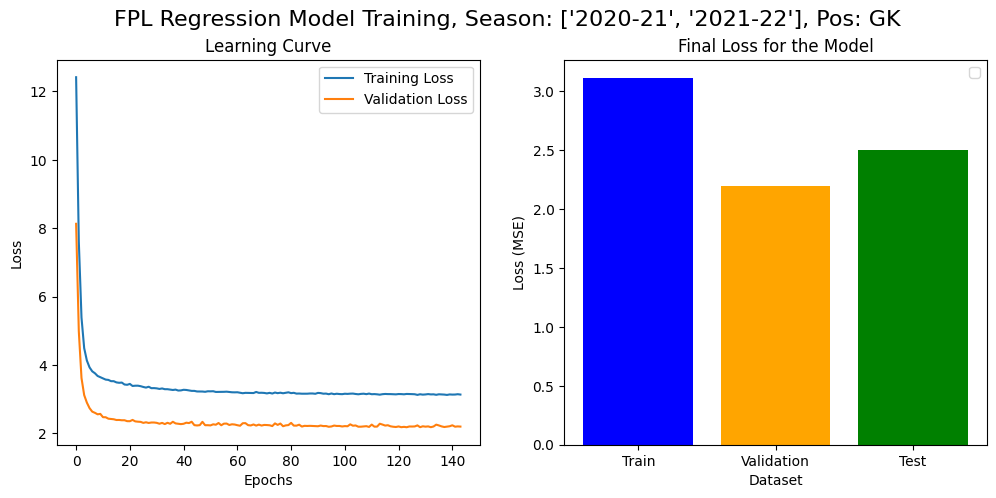

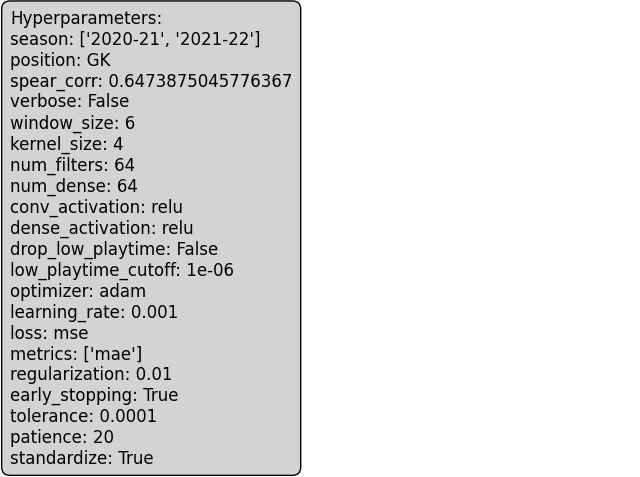

22/22 [==============================] - 0s 427us/step

Worst two examples for GK:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
103            15         3.537507  131.388739     0.0          7         10   
326             9         0.009383   80.831197     1.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
103          2          8          3          5  
326          0          0          0          0


Best two examples for GK:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
514             0         0.000101  1.024923e-08     3.0          0   
517             0         0.000101  1.024923e-08     3.0          0   

     pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  
514          0          0          0          0          0  
517          0          0          0          0          0

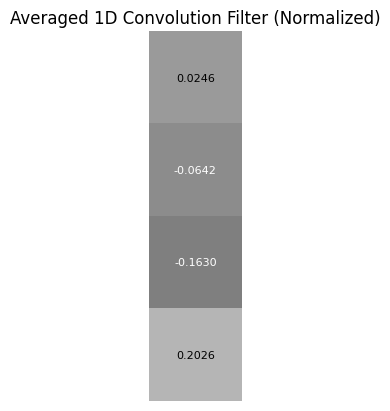


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (7556, 9, 1)
X_val shape: (3303, 9, 1)
X_test shape: (1937, 9, 1)
Epoch 100: early stopping
61/61 [==============================] - 0s 404us/step


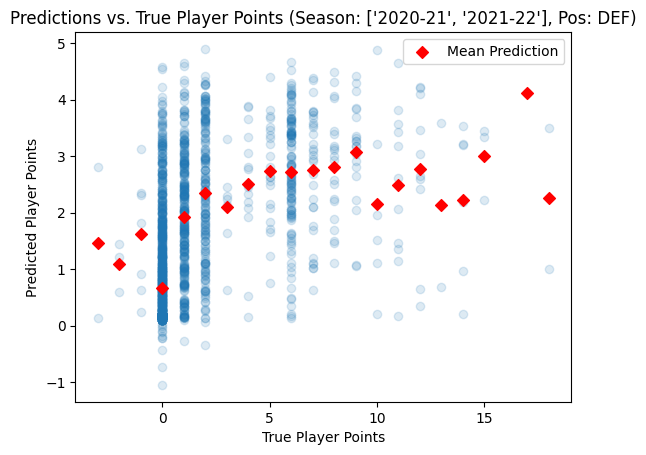

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.371225833892822, Test Mean Absolute Error (MAE): 1.3266873359680176, Test Spearman Correlation: 0.6281046867370605


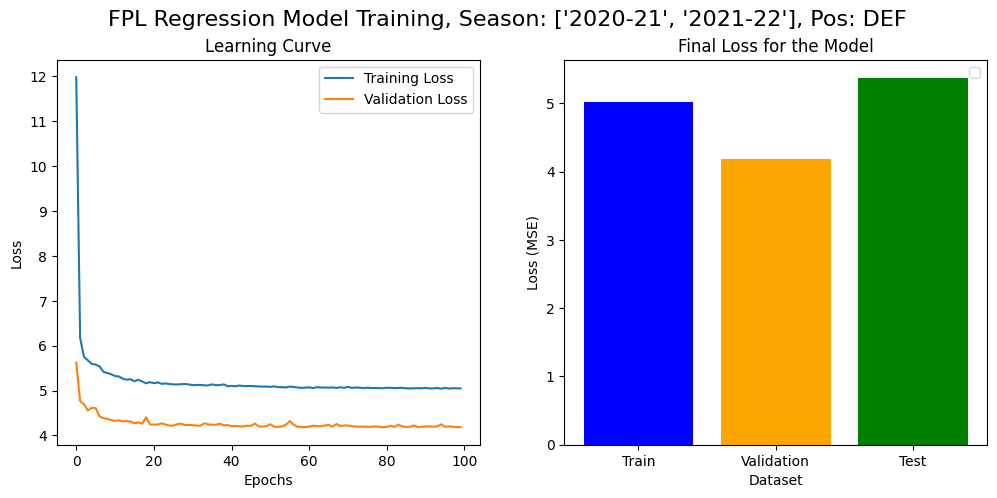

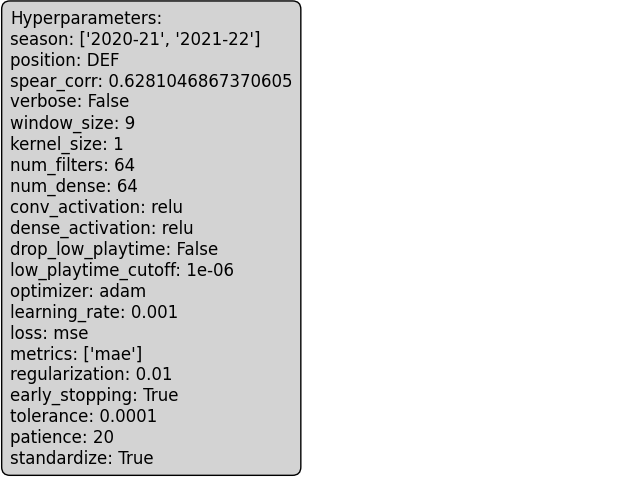

61/61 [==============================] - 0s 370us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1626            18         1.008223  288.720480     2.0          0          1   
713             18         3.493438  210.440334     2.0          1          6   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1626          0          4          1          0          1          1   
713           0          1          2          2          0          4   

      pts_week8  
1626          0  
713           6


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
688             2         1.992977  0.000049     0.0          2          1   
371             0        -0.002928  0.000009     1.0         -1          0   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
688          0          2          6          2          2          1   
371          0          0          0          0          0          0   

     pts_week8  
688          0  
371          0

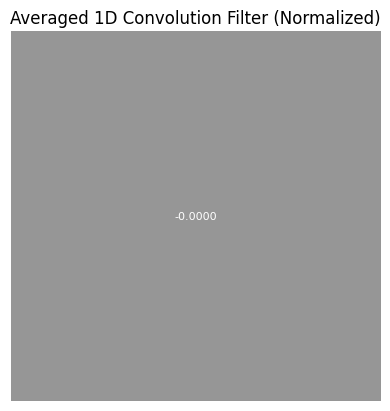


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (10275, 6, 1)
X_val shape: (4273, 6, 1)
X_test shape: (2261, 6, 1)
Epoch 112: early stopping
71/71 [==============================] - 0s 312us/step


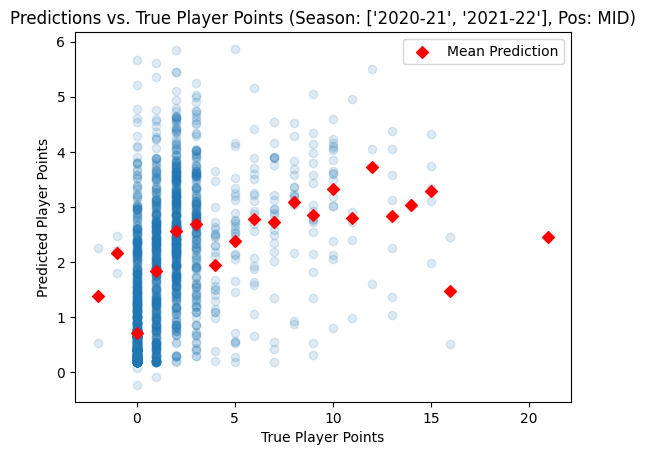

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 4.066883563995361, Test Mean Absolute Error (MAE): 1.1712664365768433, Test Spearman Correlation: 0.6683037877082825


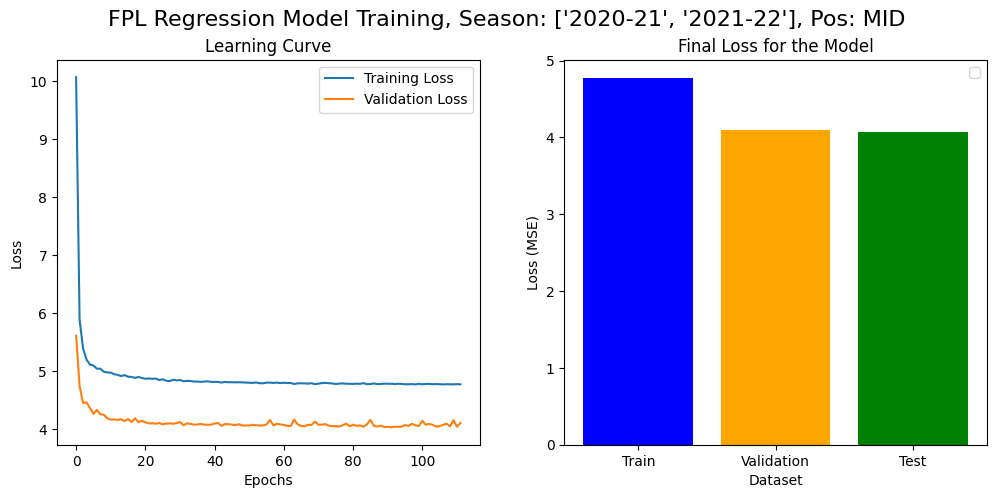

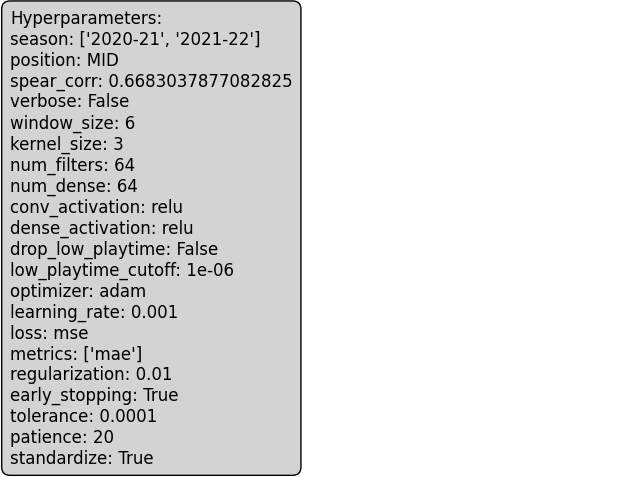

71/71 [==============================] - 0s 320us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
87              21         2.453412  343.975942    -2.0          2          3   
2100            16         0.503880  240.129738     0.0          2          2   

      pts_week2  pts_week3  pts_week4  pts_week5  
87            3          2          3          2  
2100          0          0          0          0


Best two examples for MID:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
671              1         0.999033  9.353694e-07    -1.0          0   
2222             1         0.999033  9.353694e-07    -1.0          0   

      pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  
671           0          0          0          1          1  
2222          0          0          0          1          1

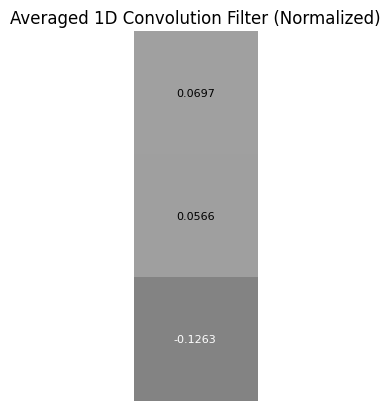


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (2741, 9, 1)
X_val shape: (1298, 9, 1)
X_test shape: (796, 9, 1)
Epoch 53: early stopping
25/25 [==============================] - 0s 404us/step


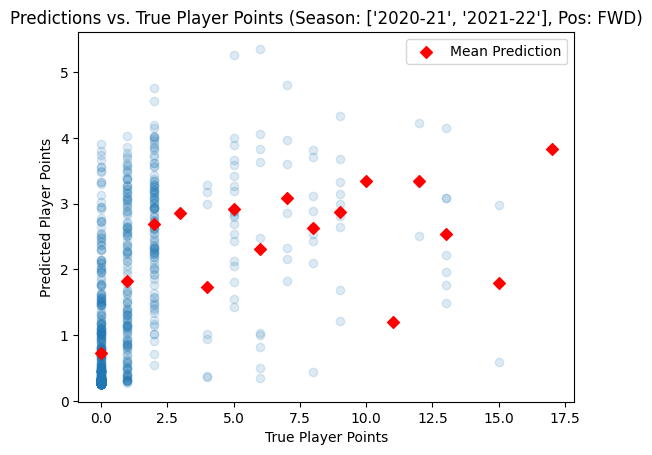

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 4.842100620269775, Test Mean Absolute Error (MAE): 1.230324625968933, Test Spearman Correlation: 0.6727957129478455


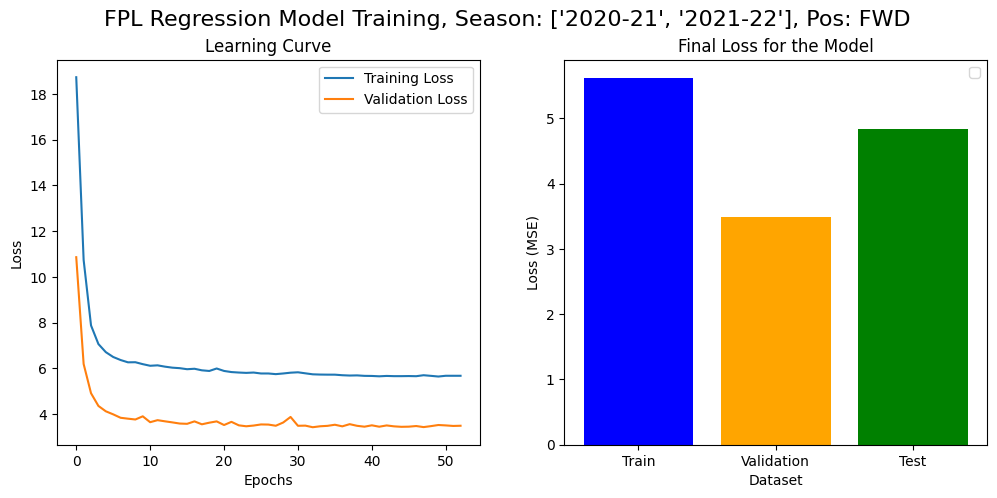

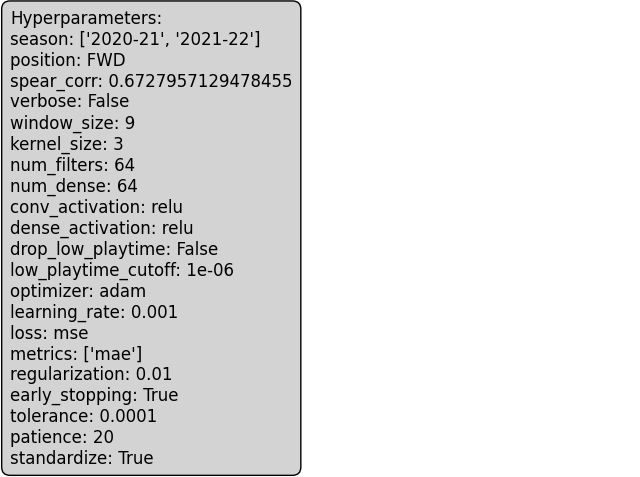

25/25 [==============================] - 0s 404us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
496            15         0.598137  207.413662    -2.0          5          2   
280            17         3.827798  173.506915     2.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
496          1          0          1          0          0          1   
280          6          2          0          0          2          9   

     pts_week8  
496          0  
280          9


Best two examples for FWD:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
712             2         2.009964  9.927633e-05    -1.0          0   
621             2         1.999648  1.240895e-07    -2.0          1   

     pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  \
712          2          2          2          2          2          2   
621          1          1          2          2          1          1   

     pts_week7  pts_week8  
712          1          1  
621          1          2

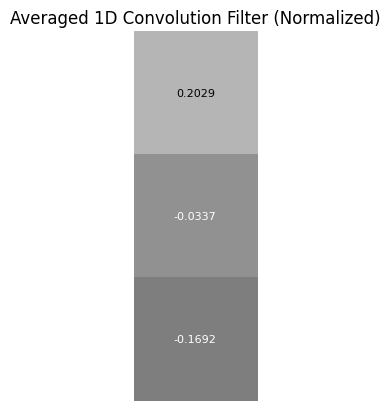

In [ ]:
# easier model
best_models = investigate_model('gridsearch_v11', drop_low_playtime=False, stratify_by='stdev')

## Worse Stability with 'Skill' instead of 'stdev'? 
### Ans: No Significant Diff. -> Skill the better stratification for performance based on top 1 and top 5


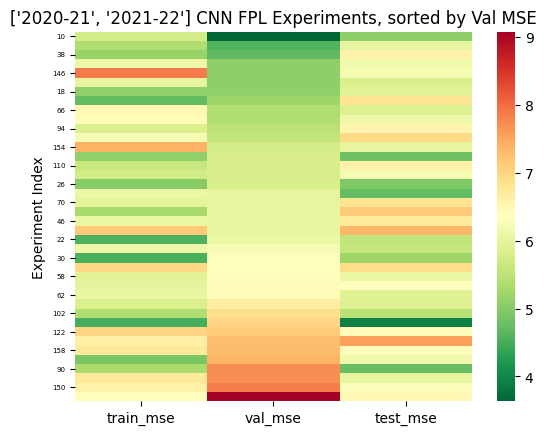


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           1          64   
DEF  ['2020-21', '2021-22']      DEF           9           1          64   
MID  ['2020-21', '2021-22']      MID           3           2          64   
FWD  ['2020-21', '2021-22']      FWD           9           1          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK        20        True          ptsonly   
DEF       20        True          ptsonly   
MID       20        True          ptsonly   
FWD       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    5.758777  3.636904  5.080052   1.640157  1.115866  1.486512
DEF   6.506676  5.388078  5.874408   1.737131  1.494645  1.646602
MID   6.135582  5.064047  6.164762   1.440681  1.353201  1.395409
FWD   7.885064  5.066278  6.216806   1.808108  1.394910  1.540545


Average Val MSE:
4.788826763629913

Average Test MSE:
5.834007263183594


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           1          64   
DEF  ['2020-21', '2021-22']      DEF           9           1          64   
MID  ['2020-21', '2021-22']      MID           3           2          64   
FWD  ['2020-21', '2021-22']      FWD           9           1          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK        20        True          ptsonly   
DEF       20        True          ptsonly   
MID       20        True          ptsonly   
FWD       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]

In [ ]:
gridsearch_analysis('gridsearch_v11', drop_low_playtime=True, stratify_by='skill', eval_top=1)


 ========= Interesting Model (DROP BENCHWARMERS) ==========


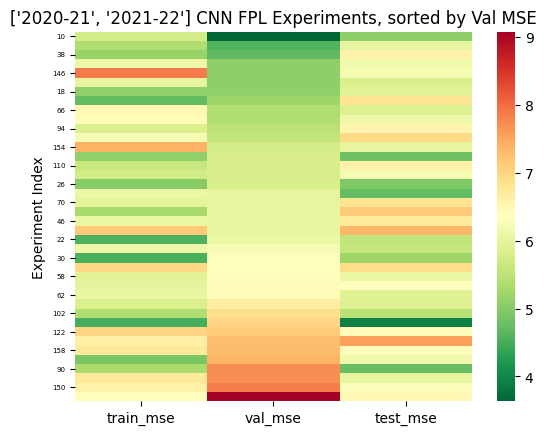


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           1          64   
DEF  ['2020-21', '2021-22']      DEF           9           1          64   
MID  ['2020-21', '2021-22']      MID           3           2          64   
FWD  ['2020-21', '2021-22']      FWD           9           1          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK        20        True          ptsonly   
DEF       20        True          ptsonly   
MID       20        True          ptsonly   
FWD       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    5.758777  3.636904  5.080052   1.640157  1.115866  1.486512
DEF   6.506676  5.388078  5.874408   1.737131  1.494645  1.646602
MID   6.135582  5.064047  6.164762   1.440681  1.353201  1.395409
FWD   7.885064  5.066278  6.216806   1.808108  1.394910  1.540545


Average Val MSE:
4.788826763629913

Average Test MSE:
5.834007263183594

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (1491, 6, 1)
X_val shape: (600, 6, 1)
X_test shape: (411, 6, 1)
Epoch 159: early stopping
13/13 [==============================] - 0s 392us/step


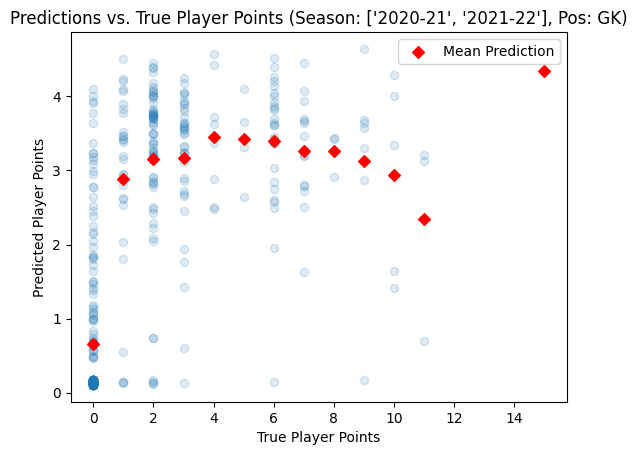

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.0739240646362305, Test Mean Absolute Error (MAE): 1.4378752708435059, Test Spearman Correlation: 0.7011550068855286


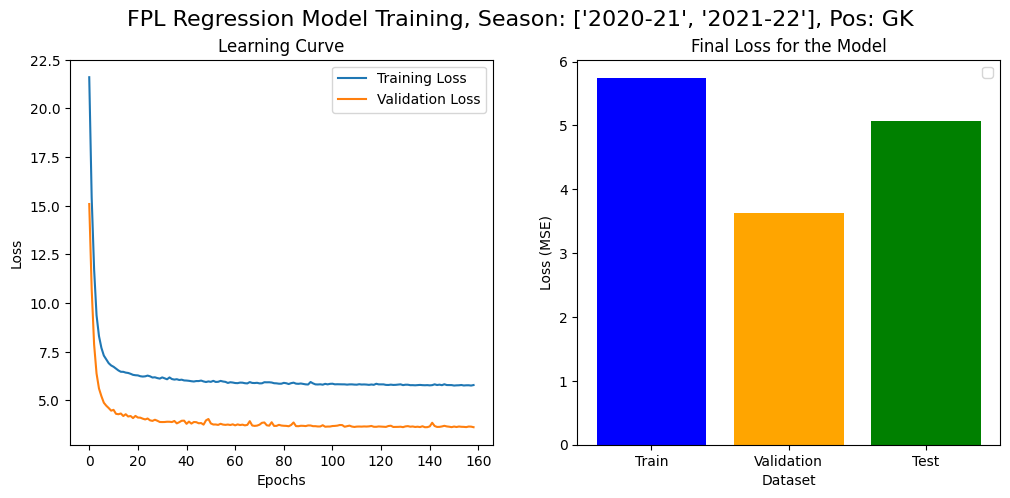

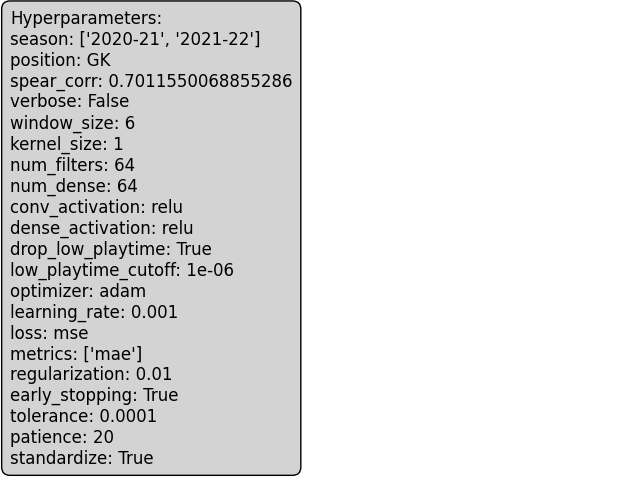

13/13 [==============================] - 0s 491us/step

Worst two examples for GK:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
33             15         4.343922  113.552006     2.0          1          7   
361            11         0.692332  106.248018     0.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
33           6          2          7          2  
361          1          2          0          0


Best two examples for GK:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
410             2         2.089832  0.008070     2.0          1          0   
406             2         2.044618  0.001991     0.0          2          1   

     pts_week2  pts_week3  pts_week4  pts_week5  
410          2          3          7          0  
406          2          2          1          0

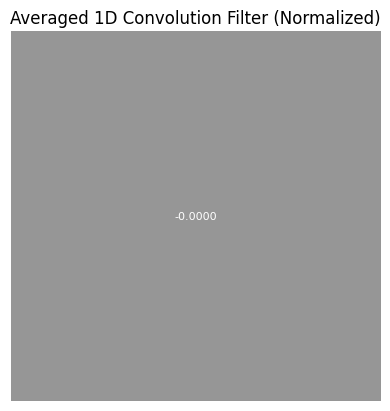


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (6028, 9, 1)
X_val shape: (2432, 9, 1)
X_test shape: (1619, 9, 1)
Epoch 88: early stopping
51/51 [==============================] - 0s 361us/step


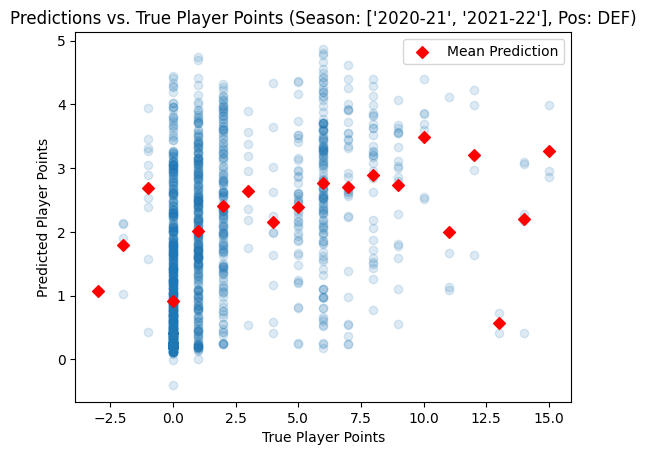

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.858004570007324, Test Mean Absolute Error (MAE): 1.5942758321762085, Test Spearman Correlation: 0.5678306818008423


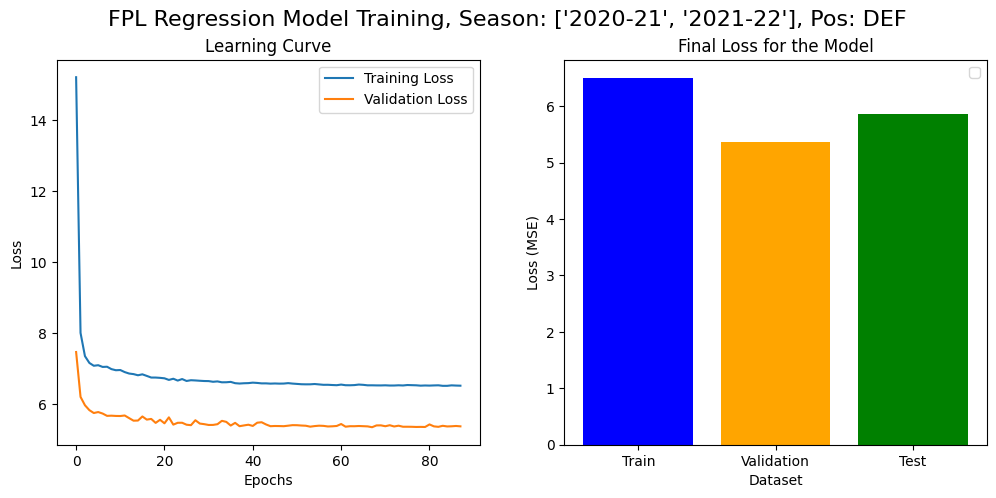

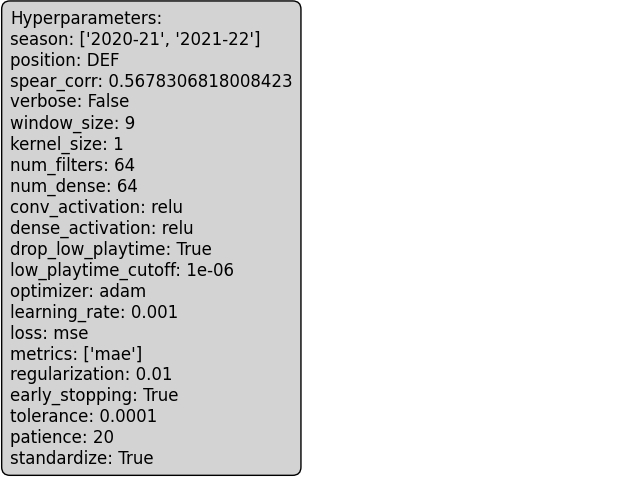

51/51 [==============================] - 0s 386us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
269            14         0.413652  184.588850     2.0          0          0   
475            13         0.413652  158.416154     2.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
269          0          0          0          0          0          0   
475          0          0          0          0          0          0   

     pts_week8  
269          0  
475          0


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
370             2         2.003357  0.000011    -1.0          0          7   
153             1         1.003312  0.000011     0.0          1          1   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
370          0          1          1          1          1          2   
153          1          2          0          0          1          1   

     pts_week8  
370          1  
153          0

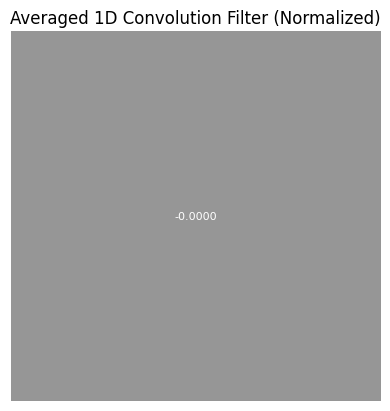


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (8639, 3, 1)
X_val shape: (3462, 3, 1)
X_test shape: (2008, 3, 1)
Epoch 189: early stopping
63/63 [==============================] - 0s 315us/step


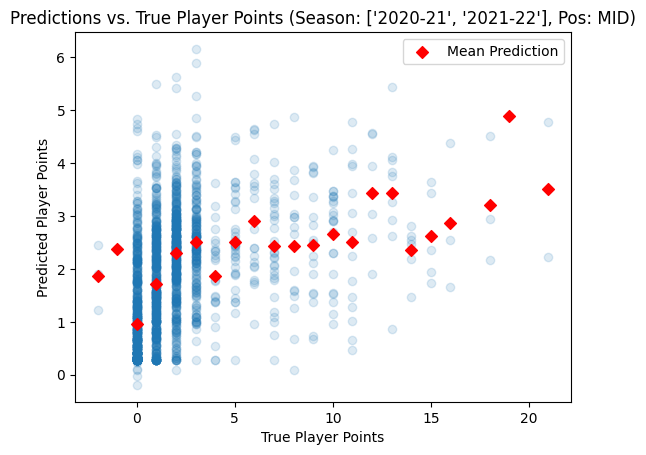

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 6.124237537384033, Test Mean Absolute Error (MAE): 1.4087711572647095, Test Spearman Correlation: 0.5820675492286682


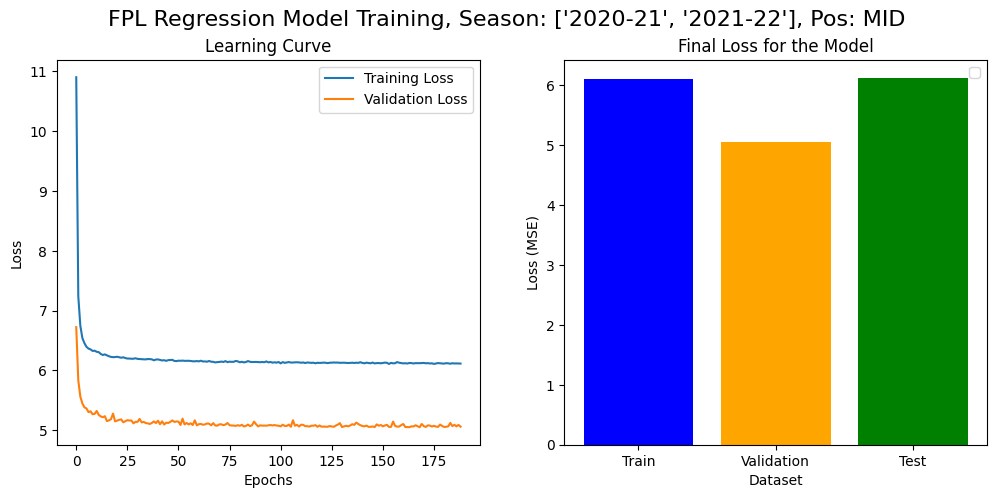

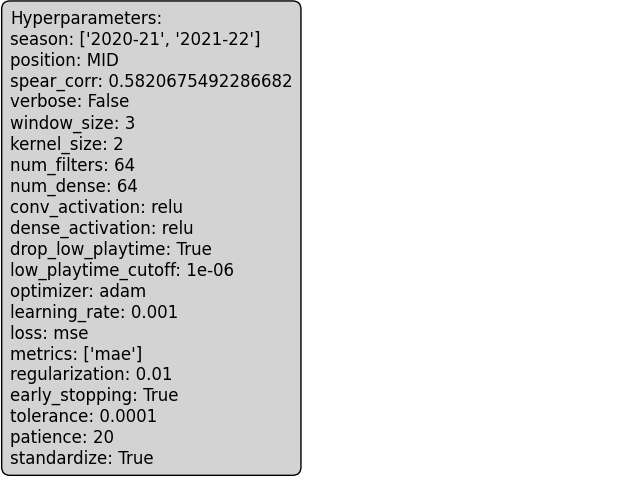

63/63 [==============================] - 0s 339us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
96              21         2.221859  352.618562    -2.0          2          3   
1445            21         4.779888  263.092044     2.0          3         15   

      pts_week2  
96            2  
1445         12


Best two examples for MID:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
594              1         1.000852  7.258849e-07     1.0          0   
1713             1         1.000852  7.258849e-07     1.0          0   

      pts_week1  pts_week2  
594           0          1  
1713          0          1

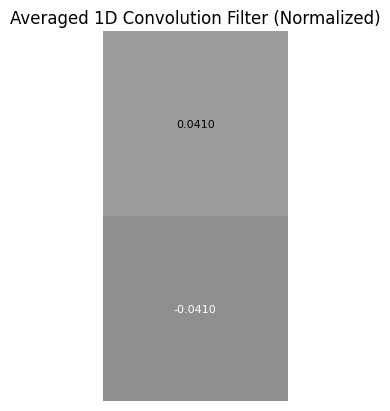


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (1993, 9, 1)
X_val shape: (894, 9, 1)
X_test shape: (503, 9, 1)
Epoch 65: early stopping
16/16 [==============================] - 0s 431us/step


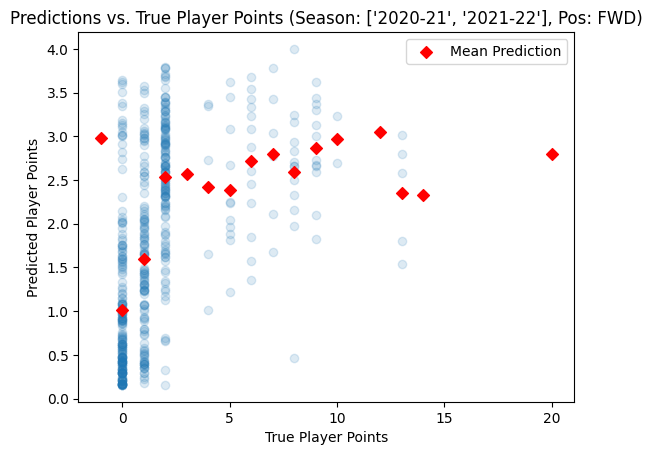

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 6.28579044342041, Test Mean Absolute Error (MAE): 1.501935362815857, Test Spearman Correlation: 0.6091989278793335


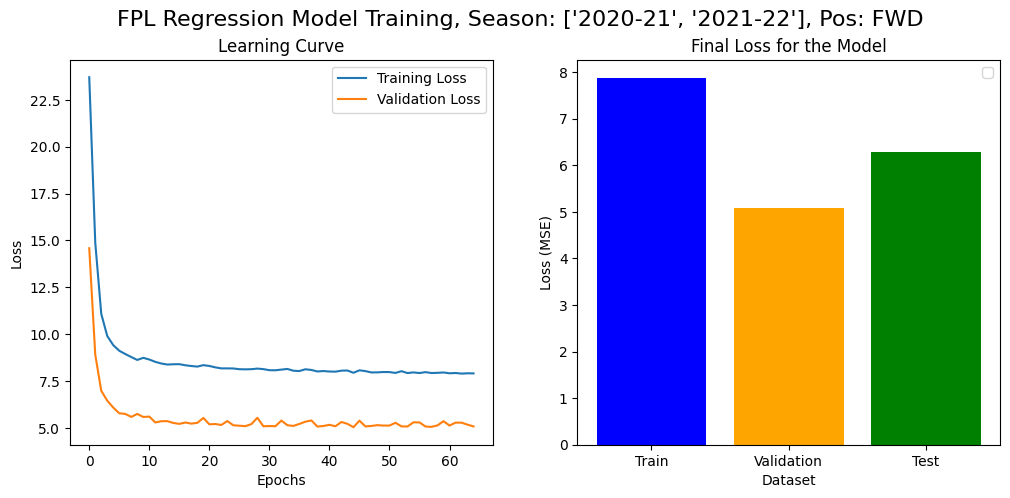

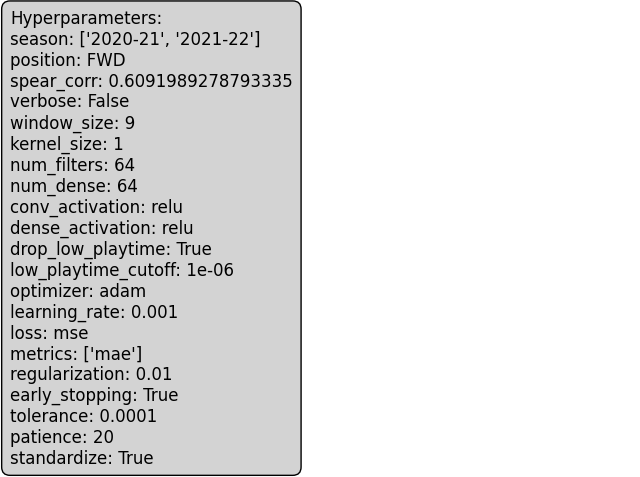

16/16 [==============================] - 0s 390us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
33             20         2.798775  295.882127    -1.0          0          0   
333            14         2.323641  136.337352    -2.0          1          1   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
33           1          2          9          8         10          5   
333          6          1          1          2         12          0   

     pts_week8  
33           2  
333          2


Best two examples for FWD:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
410             2         1.977163  5.215142e-04     1.0          1   
40              1         0.999166  6.948405e-07     0.0          8   

     pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  \
410          1          4          0          1          1          1   
40           1          1          1          1          1          1   

     pts_week7  pts_week8  
410          1          1  
40           0          0

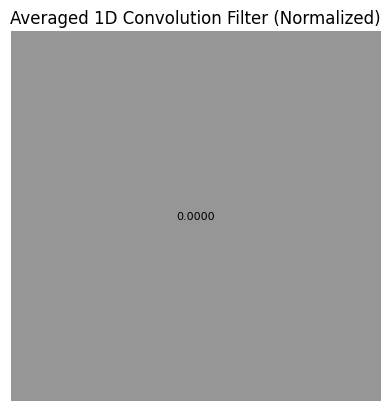

In [ ]:
print(f"\n ========= Interesting Model (DROP BENCHWARMERS) ==========")
best_models = investigate_model('gridsearch_v11', drop_low_playtime=True, stratify_by='skill')


 ========= Easier Model (FULL DATA) ==========


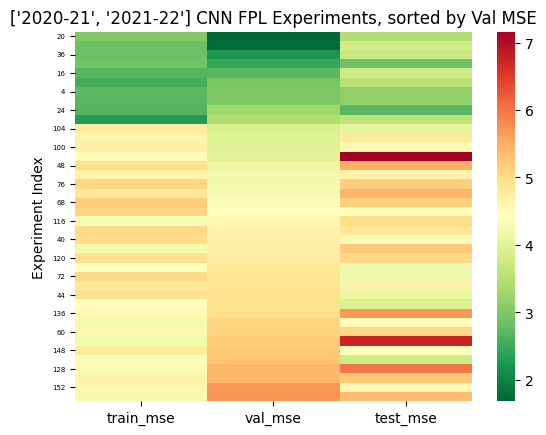


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           4          64   
DEF  ['2020-21', '2021-22']      DEF           6           1          64   
MID  ['2020-21', '2021-22']      MID           9           1          64   
FWD  ['2020-21', '2021-22']      FWD           9           1          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK        20        True          ptsonly   
DEF       20        True          ptsonly   
MID       20        True          ptsonly   
FWD       20        True          ptsonly   

                                               dataset  \
GK   b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.028097  1.679861  3.440394   0.921610  0.568471  0.957693
DEF   4.940764  4.125205  5.499934   1.265650  1.103183  1.359498
MID   4.795315  3.894319  4.066744   1.176387  0.960564  1.020117
FWD   4.466862  4.003593  7.166470   1.119584  1.134825  1.376969


Average Val MSE:
3.4257445335388184

Average Test MSE:
5.0433855056762695

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (2911, 6, 1)
X_val shape: (1121, 6, 1)
X_test shape: (667, 6, 1)
Epoch 239: early stopping
21/21 [==============================] - 0s 395us/step


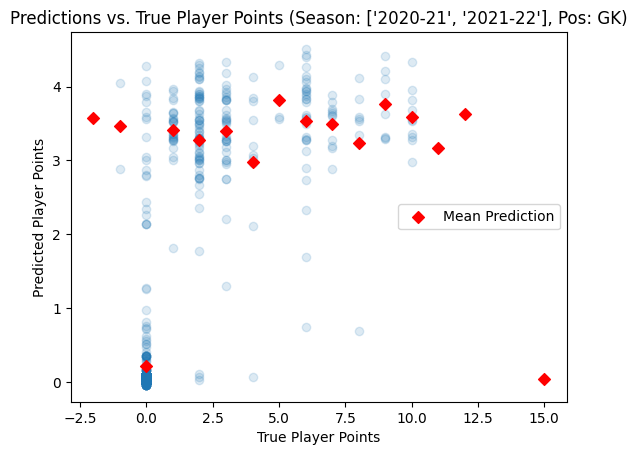

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 3.4232378005981445, Test Mean Absolute Error (MAE): 0.9192090630531311, Test Spearman Correlation: 0.741434633731842


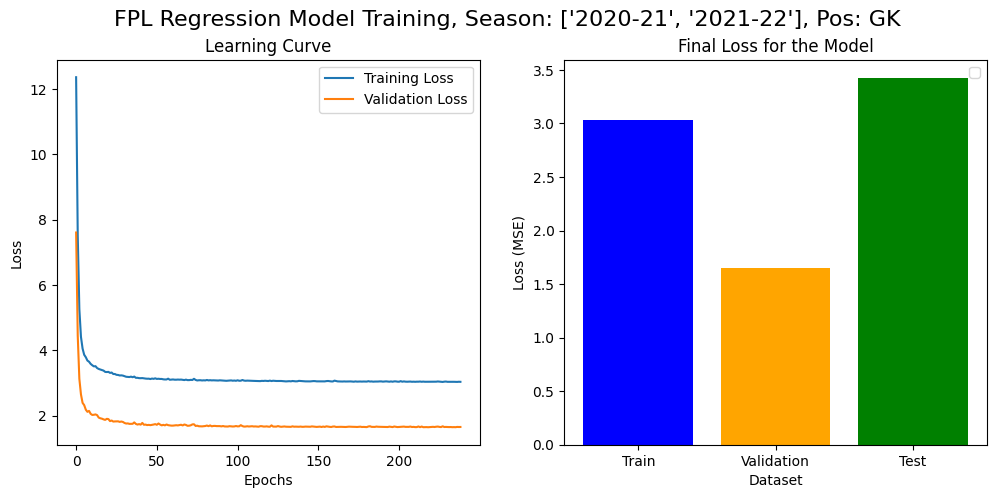

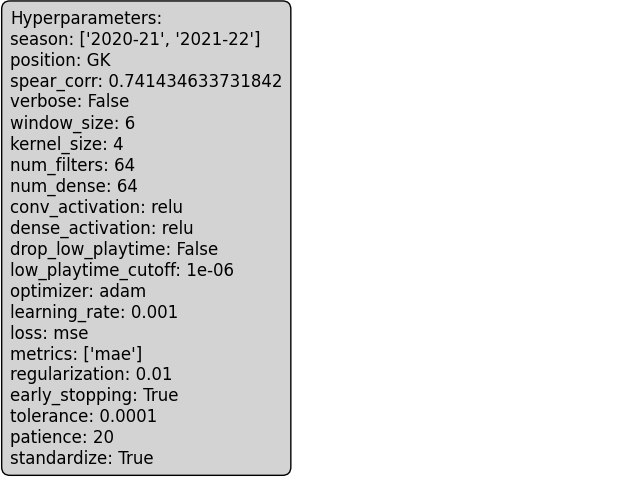

21/21 [==============================] - 0s 402us/step

Worst two examples for GK:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
297            15         0.043555  223.695235    -2.0          1          2   
189            12         3.636047   69.955708     0.0          3          6   

     pts_week2  pts_week3  pts_week4  pts_week5  
297          2          1          7         -1  
189          1         10          4          9


Best two examples for GK:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
216             3         3.008455  0.000071    -2.0          2          3   
215             3         3.003074  0.000009    -2.0          2          2   

     pts_week2  pts_week3  pts_week4  pts_week5  
216          9          3          8          3  
215          3          9          3          8

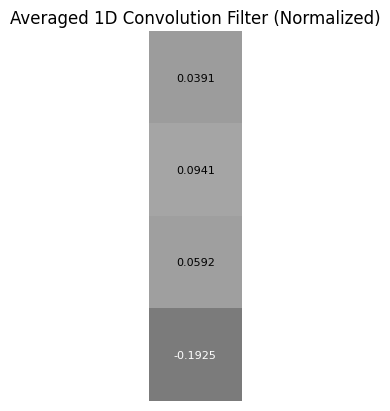


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (8679, 6, 1)
X_val shape: (3406, 6, 1)
X_test shape: (2156, 6, 1)
Epoch 89: early stopping
68/68 [==============================] - 0s 302us/step


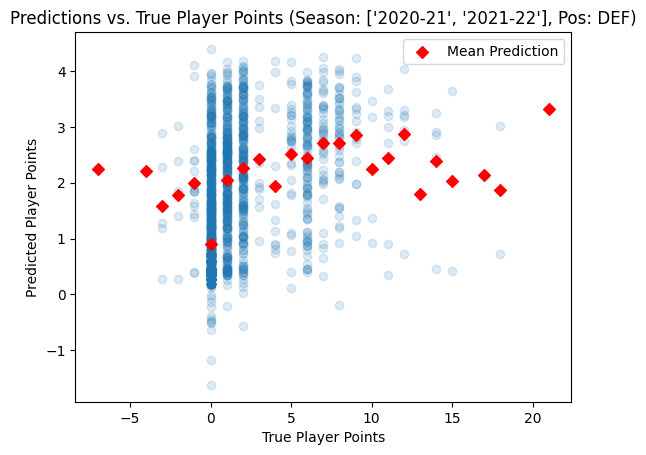

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.4940290451049805, Test Mean Absolute Error (MAE): 1.498970627784729, Test Spearman Correlation: 0.5669150352478027


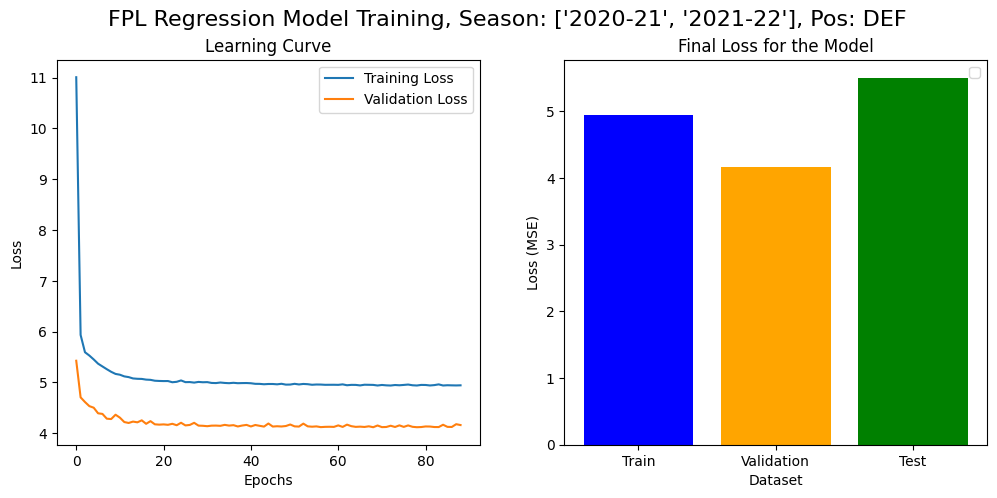

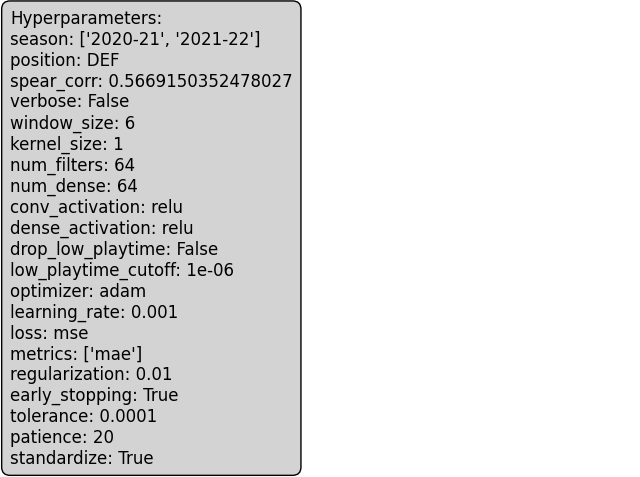

68/68 [==============================] - 0s 370us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1966            21         3.321192  312.540251     1.0          0          0   
1982            18         0.721634  298.541931     2.0          1          0   

      pts_week2  pts_week3  pts_week4  pts_week5  
1966          1          0          1         13  
1982          0          0          0          0


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
674             1         1.007295  0.000053    -1.0          1          2   
482             0        -0.005029  0.000025    -1.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
674         -7          0          0          2  
482         -3          0          0          0

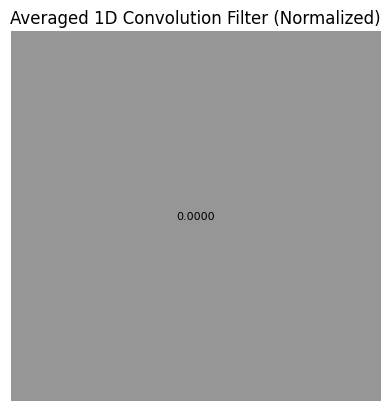


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (8827, 9, 1)
X_val shape: (3983, 9, 1)
X_test shape: (2249, 9, 1)
Epoch 104: early stopping
71/71 [==============================] - 0s 411us/step


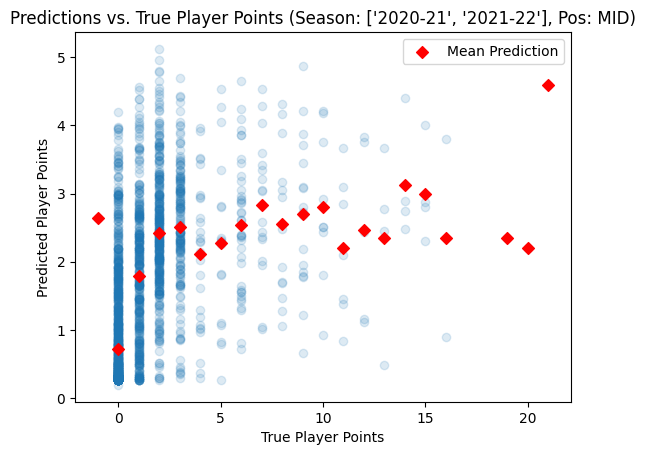

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 4.092218399047852, Test Mean Absolute Error (MAE): 1.110930323600769, Test Spearman Correlation: 0.6743927001953125


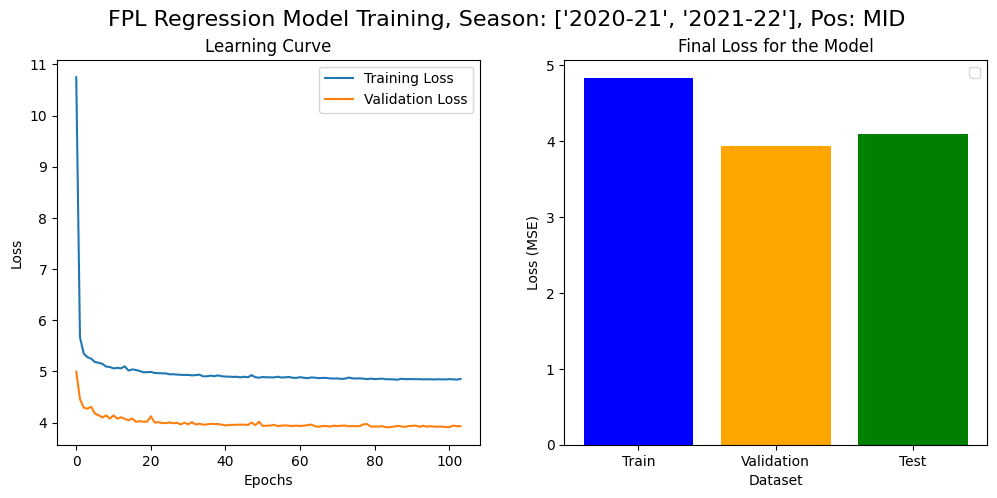

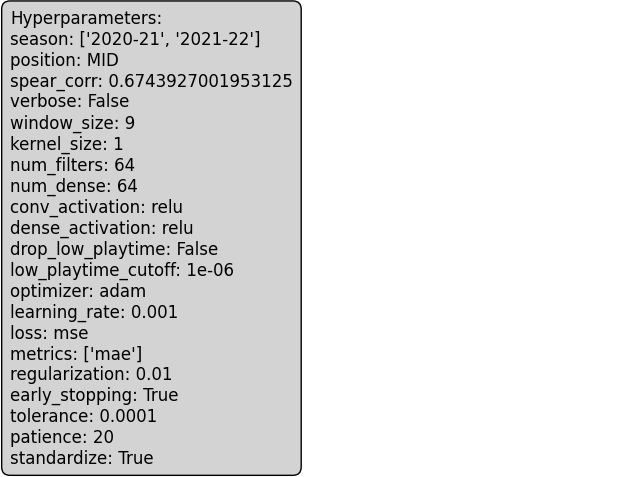

71/71 [==============================] - 0s 379us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
540            20         2.195798  316.989603     1.0          0          3   
568            19         2.351999  277.155928     2.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
540          3          3         15          0          0          1   
568          0          1          2          0          0          1   

     pts_week8  
540          1  
568          4


Best two examples for MID:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
613             2         2.002487  6.183706e-06    -1.0          0   
96              1         1.000586  3.437140e-07    -2.0          1   

     pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  \
613          0          0          0          0          1          5   
96           2          0          2          3          1          0   

     pts_week7  pts_week8  
613          2          2  
96           1          0

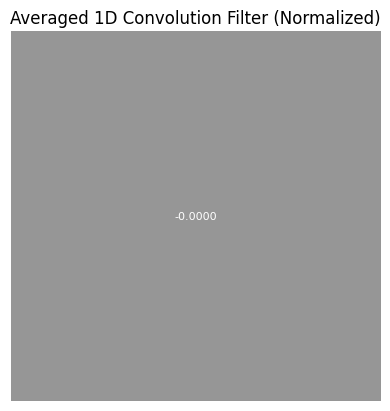


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (2766, 9, 1)
X_val shape: (1259, 9, 1)
X_test shape: (810, 9, 1)
Epoch 74: early stopping
26/26 [==============================] - 0s 377us/step


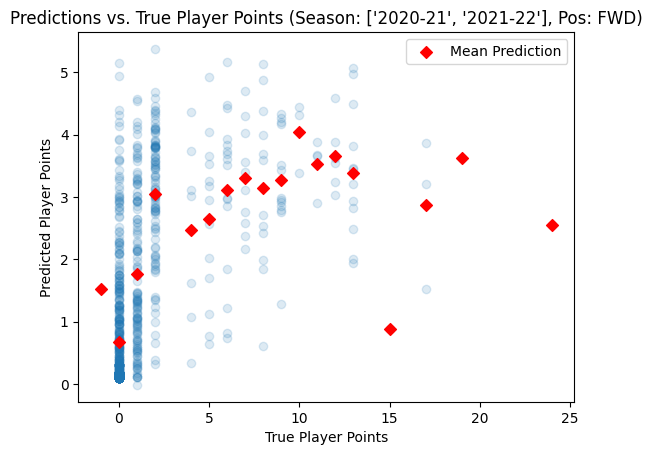

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 7.165493965148926, Test Mean Absolute Error (MAE): 1.4222224950790405, Test Spearman Correlation: 0.684952437877655


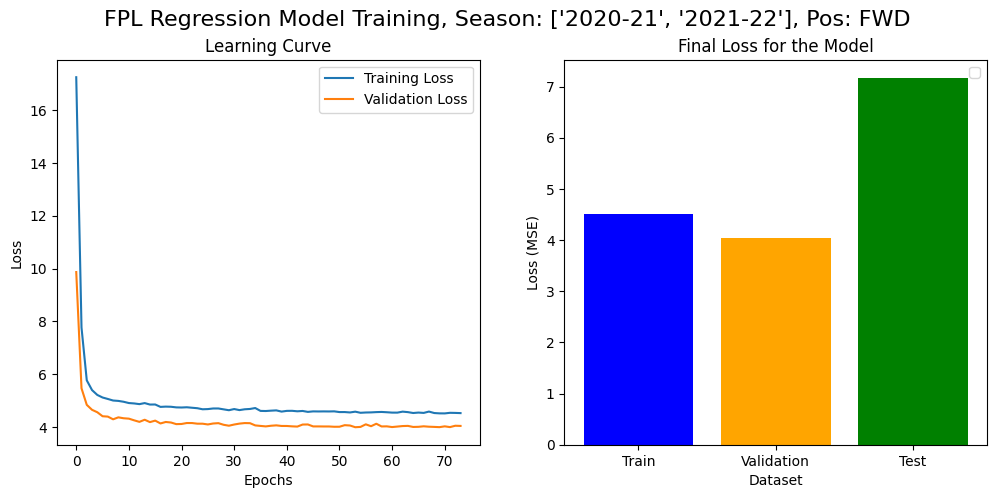

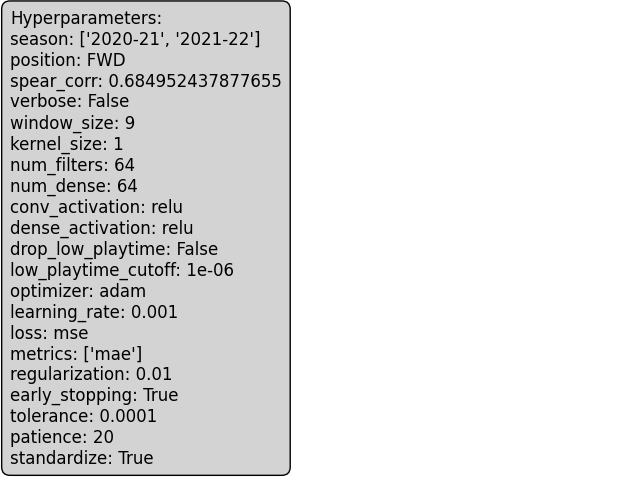

26/26 [==============================] - 0s 386us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
491            24         2.546334  460.259794     3.0          0          0   
542            17         1.527468  239.399255     0.0          0          2   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
491          0          1          0          0          1          9   
542          2          1          2          8          1          2   

     pts_week8  
491          1  
542          0


Best two examples for FWD:



Actual Score  Predicted Score           MSE  d_test  pts_week0  \
241             1         1.014502  2.102990e-04     2.0          6   
715             2         1.999952  2.262382e-09     1.0          1   

     pts_week1  pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  \
241          0          0          1          2          1          1   
715          1          4          0          1          1          1   

     pts_week7  pts_week8  
241          0          0  
715          1          1

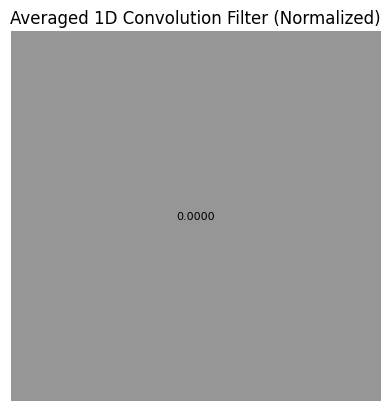

In [ ]:
print(f"\n ========= Easier Model (FULL DATA) ==========")
best_models = investigate_model('gridsearch_v11', drop_low_playtime=False, stratify_by='skill')

## Top 1 and Top 5 Performances

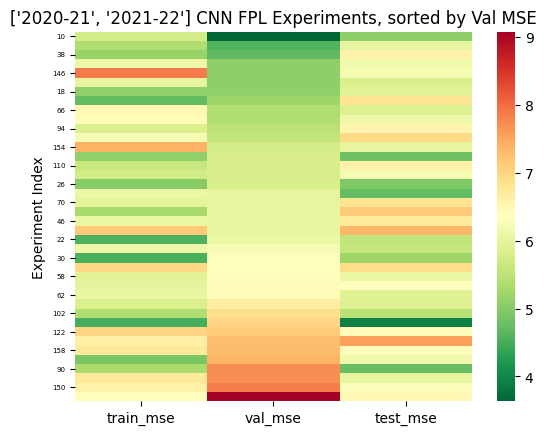


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 2 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1        64.0   
DEF  ['2020-21', '2021-22']      DEF         9.0           1        64.0   
MID  ['2020-21', '2021-22']      MID           3           2        64.0   
FWD  ['2020-21', '2021-22']      FWD         9.0           1        64.0   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK       64.0            relu             relu              True   
DEF      64.0            relu             relu              True   
MID      64.0            relu             relu              True   
FWD      64.0            relu             relu              True   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK      20.0        True          ptsonly   
DEF     20.0        True          ptsonly   
MID     20.0        True          ptsonly   
FWD     20.0        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95L2\x01\x00\x00\x00\x00\x00}\x94(...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]


['2020-21', '2021-22'] Mean Performance of Top 2 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    5.576999  4.107376  5.557086   1.629111  1.223247  1.647345
DEF   6.469422  5.391271  6.008086   1.701942  1.518705  1.606731
MID   6.087723  5.066236  5.992228   1.455705  1.355406  1.439656
FWD   7.635899  5.412219  6.128467   1.777208  1.455428  1.512921


Average Val MSE:
4.994275361299515

Average Test MSE:
5.921466708183289


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1        64.0   
DEF  ['2020-21', '2021-22']      DEF         9.0           1        64.0   
MID  ['2020-21', '2021-22']      MID           3           2        64.0   
FWD  ['2020-21', '2021-22']      FWD         9.0           1        64.0   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK       64.0            relu             relu              True   
DEF      64.0            relu             relu              True   
MID      64.0            relu             relu              True   
FWD      64.0            relu             relu              True   

    low_playtime_cutoff  ...  metrics regularization early_stopping tolerance  \
GK             0.000001  ...  ['mae']           0.01           True    0.0001   
DEF            0.000001  ...  ['mae']           0.01           True    0.0001   
MID            0.000001  ...  ['mae']           0.01           True    0.0001   
FWD            0.000001  ...  ['mae']           0.01           True    0.0001   

    patience standardize amt_num_features  \
GK      20.0        True          ptsonly   
DEF     20.0        True          ptsonly   
MID     20.0        True          ptsonly   
FWD     20.0        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95L2\x01\x00\x00\x00\x00\x00}\x94(...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline stratify_by  
GK   b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...       skill  

[4 rows x 23 columns]

In [ ]:
gridsearch_analysis('gridsearch_v11', 
                    stratify_by='skill', 
                    eval_top=2, 
                    drop_low_playtime = True)

In [ ]:
def investigate_model_v0(expt_name: str = 'gridsearch', 
                      drop_low_playtime: bool = True,
                      **kwargs):
    """
    Investigate the best model for the given experiment and drop status.

    Retrains the model on the same exact data split (to avoid data leakage), and
    generates learning curves.
    """
    season =  "['2020-21', '2021-22']"
    best_params = gridsearch_analysis(expt_name, 
                        season=season, 
                        eval_top=1,
                        drop_low_playtime=drop_low_playtime,
                        **kwargs)
    
    POSITIONS = ['GK', 'DEF', 'MID', 'FWD']
    best_models = {}
    for position in POSITIONS: 

        print(f"\n======= Retraining and Filter Analysis for {position} model: =======\n")
        # Clean up and consolidate parameters in the 'params' dictionary
        params = best_params.loc[position, :].to_dict()

        serialized_dataset = params.pop('dataset')
        dataset = pickle.loads(ast.literal_eval(serialized_dataset))

        # Retrieve individual datasets
        X_train = dataset['X_train']
        d_train = dataset['d_train']
        y_train = dataset['y_train']
        X_val = dataset['X_val']
        d_val = dataset['d_val']
        y_val = dataset['y_val']
        X_test = dataset['X_test']
        d_test = dataset['d_test']
        y_test = dataset['y_test']

        serialized_pipeline = params.pop('pipeline')
        pipeline = pickle.loads(ast.literal_eval(serialized_pipeline))

        params['season'] = ['2020-21', '2021-22']
        params['metrics'] = ['mae']
        params['num_features'] = NUM_FEATURES_DICT[params['position']][params.pop('amt_num_features')]

        # Add the datasets to params
        params.update({
            'X_train': X_train,
            'd_train': d_train,
            'y_train': y_train,
            'X_val': X_val,
            'd_val': d_val,
            'y_val': y_val,
            'X_test': X_test,
            'd_test': d_test,
            'y_test': y_test,
            'plot': True,
        })

        # =========== Qualitative Analysis of Best & Worst Ex =============

        print(f"X_train shape: {X_train.shape}")
        print(f"X_val shape: {X_val.shape}")
        print(f"X_test shape: {X_test.shape}")

        model, expt_res = build_train_cnn(**params)
        best_models[position] = model

        y_pred = model.predict([X_test, d_test])
        y_test_flattened = y_test.flatten()
        y_pred_flattened = y_pred.flatten()
        mse_per_example = np.square(y_test_flattened - y_pred_flattened)

        results_df = pd.DataFrame({'Actual Score': y_test_flattened, 'Predicted Score': y_pred_flattened, 'MSE': mse_per_example})
        results_df['d_test'] = d_test

        # Add X_test features to the DataFrame
        # unstandardize the features
        X_test_original = X_test.copy()

        # Calculate unstandardized pts
        numerical_transformer = pipeline.named_steps['preprocessor'].named_transformers_['num']
        X_test_reshaped = X_test_original.reshape(-1, X_test_original.shape[-1])
        X_test_unstandardized = numerical_transformer.inverse_transform(X_test_reshaped).astype(int)
        X_test_unstandardized = X_test_unstandardized.reshape(X_test_original.shape)
        X_test_unstandardized_2d = X_test_unstandardized.reshape(X_test_unstandardized.shape[0], -1)
        column_names = [f'pts_week{i}' for i in range(X_test_unstandardized.shape[1])]
        unstandardized_df = pd.DataFrame(X_test_unstandardized_2d, columns=column_names)

        results_df = pd.concat([results_df, unstandardized_df], axis=1)

        results_df.sort_values(by='MSE', ascending=False, inplace=True)

        print(f"\nWorst two examples for {position}:\n")
        display(results_df.head(2))

        print(f"\nBest two examples for {position}:\n")
        display(results_df.tail(2))


        for layer in model.layers:
            if 'conv' not in layer.name:
                continue
            filters, biases = layer.get_weights()

        # retrieve filter weights from the second hidden layer
        filters, biases = model.layers[1].get_weights()

        # normalize filter values by z-score normalization
        mean_value, std_dev = filters.mean(), filters.std()
        normalized_filters = (filters - mean_value) / std_dev
        mean_filter = normalized_filters.mean(axis=-1)

        # set greyscale color map
        cmap = plt.cm.Greys_r
        cmap.set_bad('0.5')  # Set the color for NaN values (if any) to medium-grey

        # plot the normalized average filter with numeric values inside pixels
        fig, ax = plt.subplots()
        img = ax.imshow(mean_filter, cmap=cmap, vmin=-1, vmax=1)

        # add text annotations with normalized values inside each pixel
        for i, value in enumerate(mean_filter):
            value = value[0]
            # set text color based on brightness
            text_color = 'white' if value < 0 else 'black'
            ax.text(0, i, f"{value:.4f}", ha='center', va='center', fontsize=8, color=text_color)
        ax.set_title("Averaged 1D Convolution Filter (Normalized)")
        ax.axis('off')
        plt.show()

    return best_models

## V10

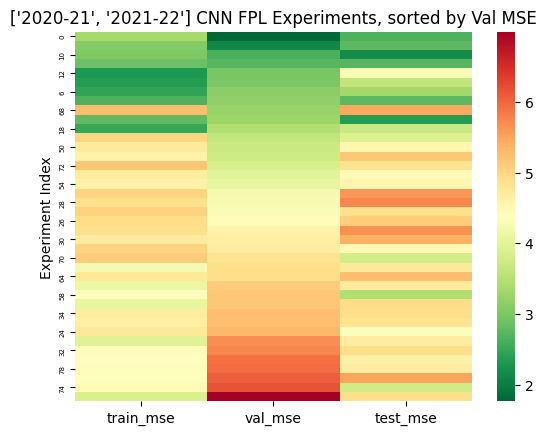


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1          64   
DEF  ['2020-21', '2021-22']      DEF           6           3          64   
MID  ['2020-21', '2021-22']      MID           9           3          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff  ... loss  metrics regularization early_stopping  \
GK             0.000001  ...  mse  ['mae']           0.01           True   
DEF            0.000001  ...  mse  ['mae']           0.01           True   
MID            0.000001  ...  mse  ['mae']           0.01           True   
FWD            0.000001  ...  mse  ['mae']           0.01           True   

    tolerance patience standardize amt_num_features  \
GK     0.0001       20        True          ptsonly   
DEF    0.0001       20        True          ptsonly   
MID    0.0001       20        True          ptsonly   
FWD    0.0001       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline  
GK   b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
DEF  b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  

[4 rows x 22 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.358335  1.764918  2.660882   0.851704  0.475254  0.653859
DEF   4.880991  4.248479  5.729393   1.402209  1.265069  1.486959
MID   4.994912  3.617579  3.920767   1.215982  1.028909  1.092197
FWD   5.271433  3.224792  5.464919   1.337546  1.013432  1.403767


Average Val MSE:
3.2139420807361603

Average Test MSE:
4.443990409374237

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (3025, 3, 1)
X_val shape: (1398, 3, 1)
X_test shape: (765, 3, 1)
Epoch 281: early stopping
24/24 [==============================] - 0s 375us/step


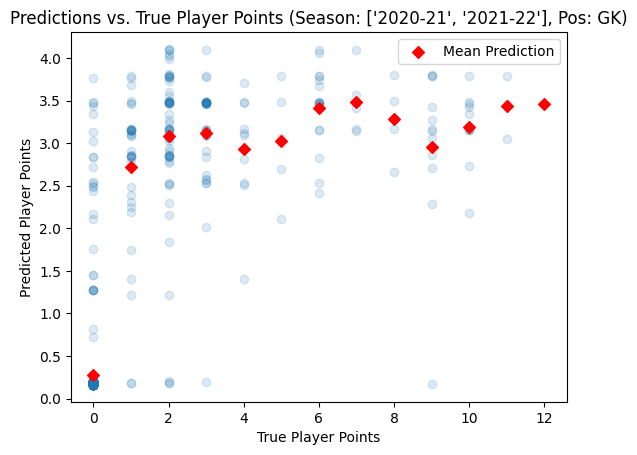

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 2.6161837577819824, Test Mean Absolute Error (MAE): 0.7833694815635681, Test Spearman Correlation: 0.7283101677894592


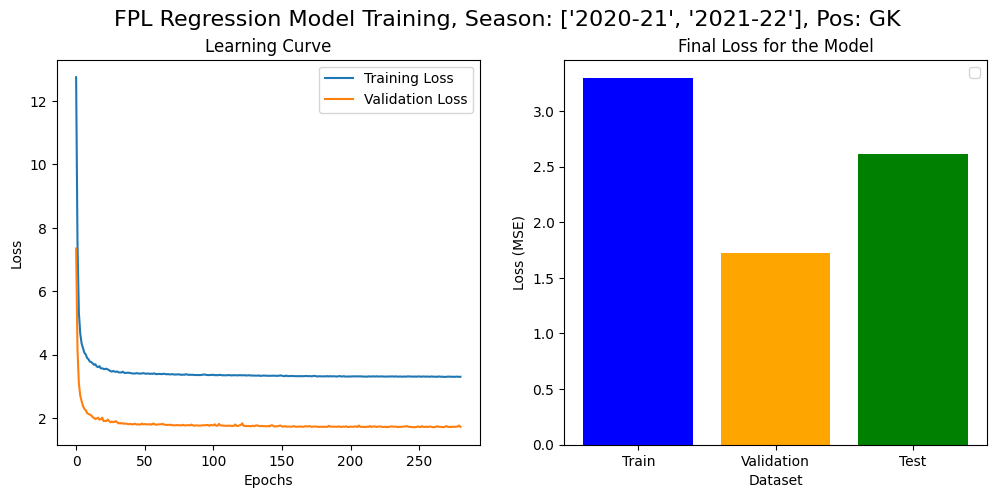

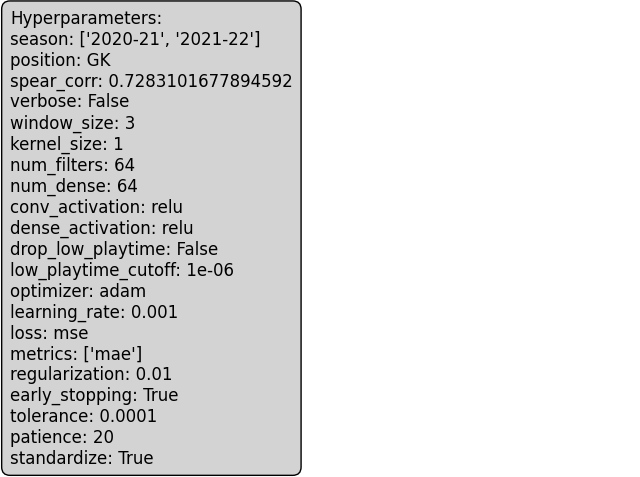

24/24 [==============================] - 0s 331us/step

Worst two examples for GK:



Actual Score  Predicted Score        MSE  d_test  pts_week0  pts_week1  \
272             9         0.168997  77.986614     1.0          0          0   
222            12         3.460268  72.927022     0.0         10          4   

     pts_week2  
272          0  
222          9


Best two examples for GK:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
372             3         2.903490  0.009314     0.0          1          2   
215             3         3.089104  0.007940    -1.0          6         10   

     pts_week2  
372          1  
215          3

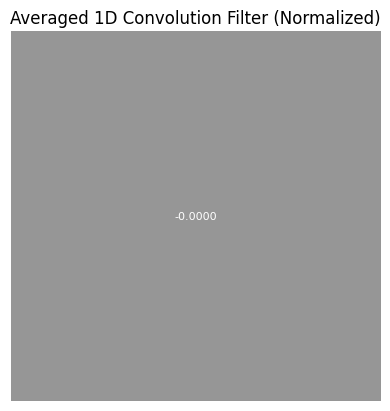


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (8402, 6, 1)
X_val shape: (3726, 6, 1)
X_test shape: (2113, 6, 1)
Epoch 123: early stopping
67/67 [==============================] - 0s 316us/step


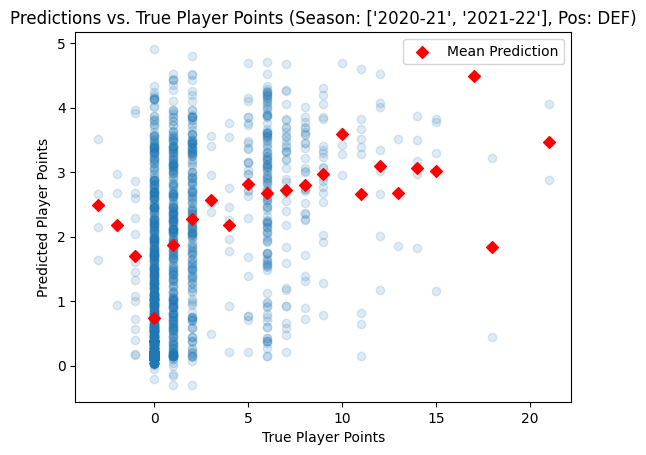

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.651356220245361, Test Mean Absolute Error (MAE): 1.3954625129699707, Test Spearman Correlation: 0.5735090970993042


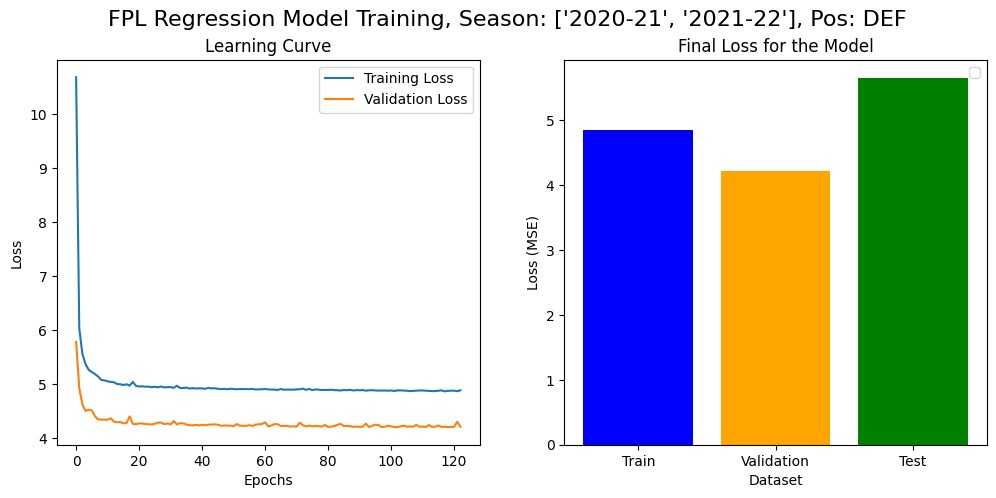

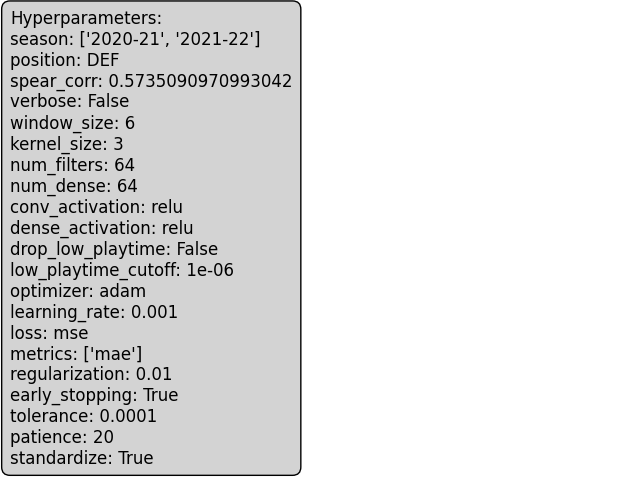

67/67 [==============================] - 0s 324us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1845            21         2.877275  328.433162     1.0          0          0   
1861            18         0.446608  308.121574     2.0          1          0   

      pts_week2  pts_week3  pts_week4  pts_week5  
1845          1          0          1         13  
1861          0          0          0          0


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
1089             1         1.002955  0.000009     0.0          3          0   
1759             1         1.002855  0.000008     0.0          4          1   

      pts_week2  pts_week3  pts_week4  pts_week5  
1089         -1          5          0          0  
1759         -1         -1          0          1

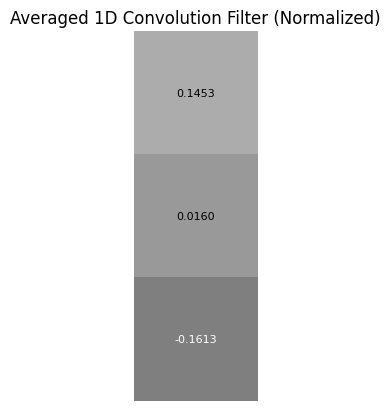


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (8729, 9, 1)
X_val shape: (3772, 9, 1)
X_test shape: (2558, 9, 1)
Epoch 121: early stopping
80/80 [==============================] - 0s 320us/step


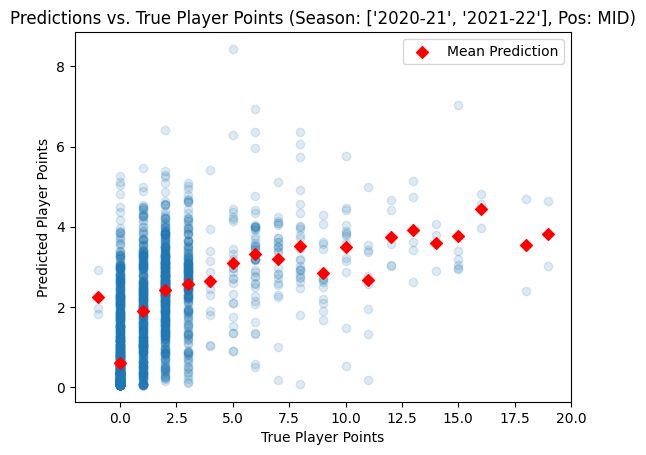

Test Loss (MSE): 3.916414499282837, Test Mean Absolute Error (MAE): 1.0774452686309814, Test Spearman Correlation: 0.6998089551925659


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


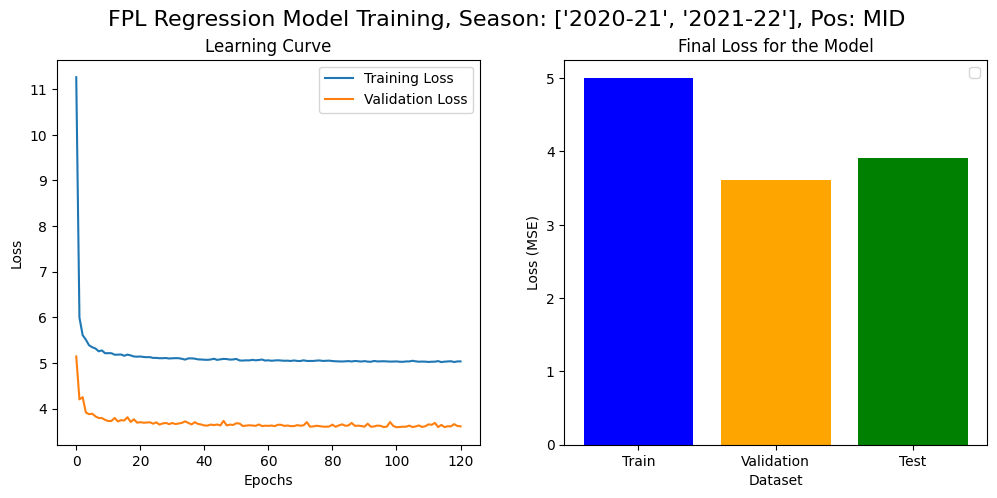

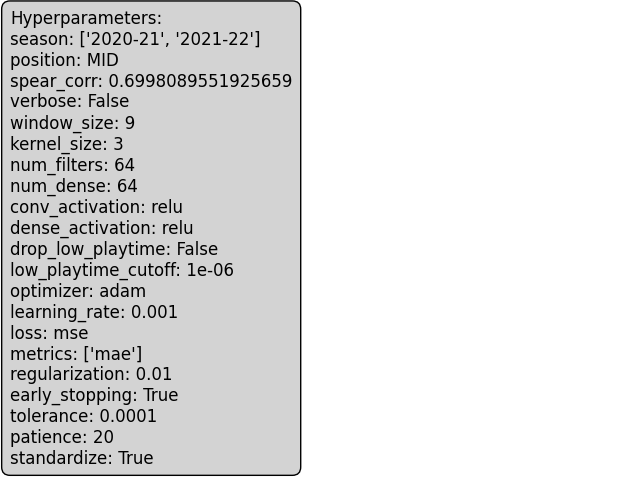

80/80 [==============================] - 0s 336us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
890             19         3.011677  255.626479     2.0          0          7   
1208            18         2.397404  243.440996     1.0          2          3   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
890           2          2          2          2          2          2   
1208          2          2          1          0          2          3   

      pts_week8  
890           2  
1208          1


Best two examples for MID:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
189              2         1.998004  0.000004    -1.0          3          0   
1199             2         2.001935  0.000004     1.0          0          0   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
189           0          0          2          0          2          1   
1199          1          0          1          3          2          3   

      pts_week8  
189           2  
1199          1

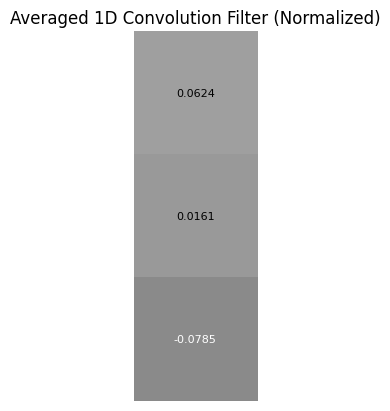


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (3223, 6, 1)
X_val shape: (1267, 6, 1)
X_test shape: (895, 6, 1)
Epoch 127: early stopping
28/28 [==============================] - 0s 320us/step


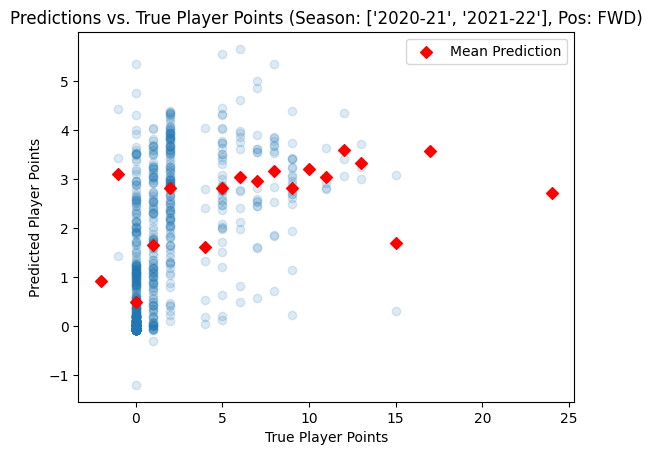

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.471902370452881, Test Mean Absolute Error (MAE): 1.284716010093689, Test Spearman Correlation: 0.6752897500991821


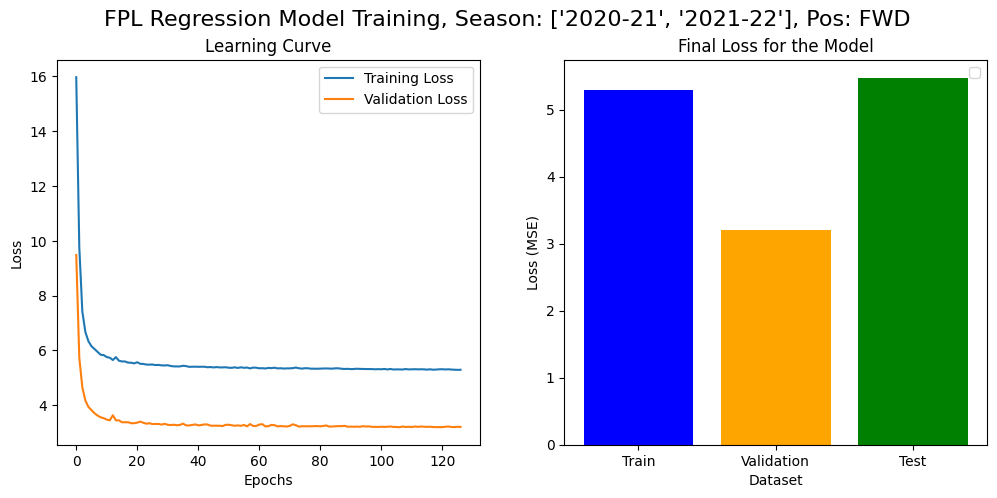

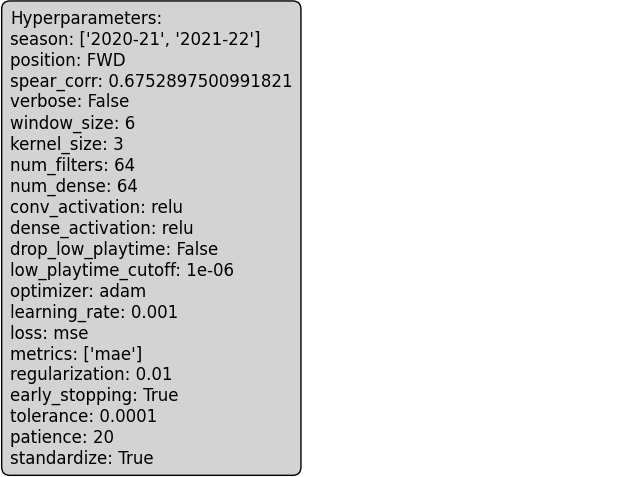

28/28 [==============================] - 0s 365us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
513            24         2.719299  452.868252     3.0          1          0   
401            15         0.302172  216.026158    -2.0          0          1   

     pts_week2  pts_week3  pts_week4  pts_week5  
513          0          1          9          1  
401          0          0          1          0


Best two examples for FWD:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
447             0         0.011822  0.000140     1.0          0          0   
333             1         1.003724  0.000014     1.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
447          0          0          0          0  
333          0          0          0          1

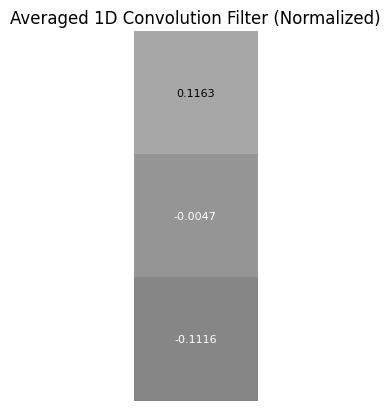

In [ ]:
# easier model
best_models = investigate_model_v0('gridsearch_v10', drop_low_playtime=False)

## DROP model

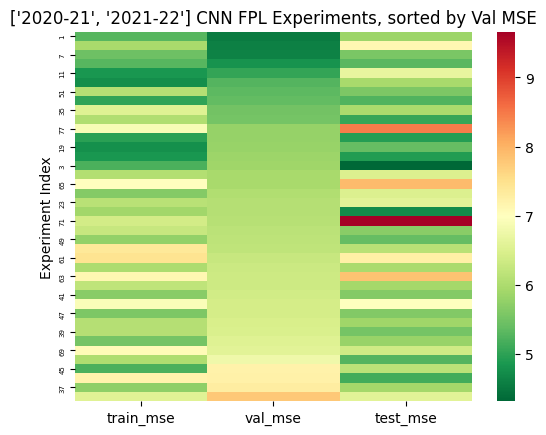


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1          64   
DEF  ['2020-21', '2021-22']      DEF           9           2          64   
MID  ['2020-21', '2021-22']      MID           9           1          64   
FWD  ['2020-21', '2021-22']      FWD           9           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff  ... loss  metrics regularization early_stopping  \
GK             0.000001  ...  mse  ['mae']           0.01           True   
DEF            0.000001  ...  mse  ['mae']           0.01           True   
MID            0.000001  ...  mse  ['mae']           0.01           True   
FWD            0.000001  ...  mse  ['mae']           0.01           True   

    tolerance patience standardize amt_num_features  \
GK     0.0001       20        True          ptsonly   
DEF    0.0001       20        True          ptsonly   
MID    0.0001       20        True          ptsonly   
FWD    0.0001       20        True          ptsonly   

                                               dataset  \
GK   b'\x80\x04\x95T3\x01\x00\x00\x00\x00\x00}\x94(...   
DEF  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline  
GK   b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
FWD  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  

[4 rows x 22 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    5.284928  4.536533  5.842735   1.472714  1.360199  1.681528
DEF   6.530591  5.485604  5.967920   1.685009  1.520161  1.533800
MID   5.950934  4.603706  7.123686   1.410807  1.242668  1.609686
FWD   6.894359  5.780006  8.469806   1.598207  1.526085  1.727002


Average Val MSE:
5.1014626026153564

Average Test MSE:
6.851036787033081

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (1510, 3, 1)
X_val shape: (748, 3, 1)
X_test shape: (487, 3, 1)
Epoch 231: early stopping
16/16 [==============================] - 0s 339us/step


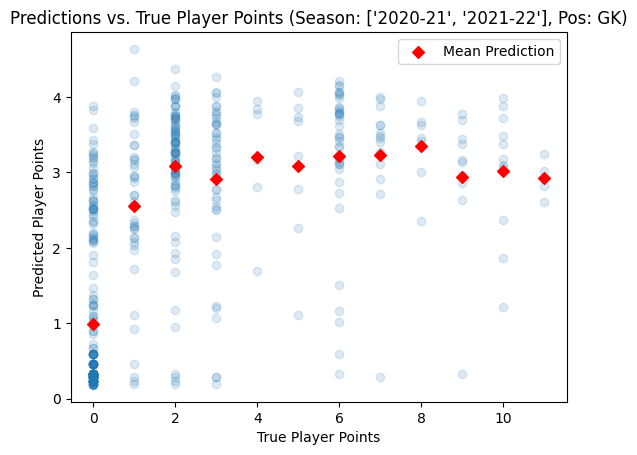

Test Loss (MSE): 5.868426322937012, Test Mean Absolute Error (MAE): 1.6821688413619995, Test Spearman Correlation: 0.6571215391159058


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


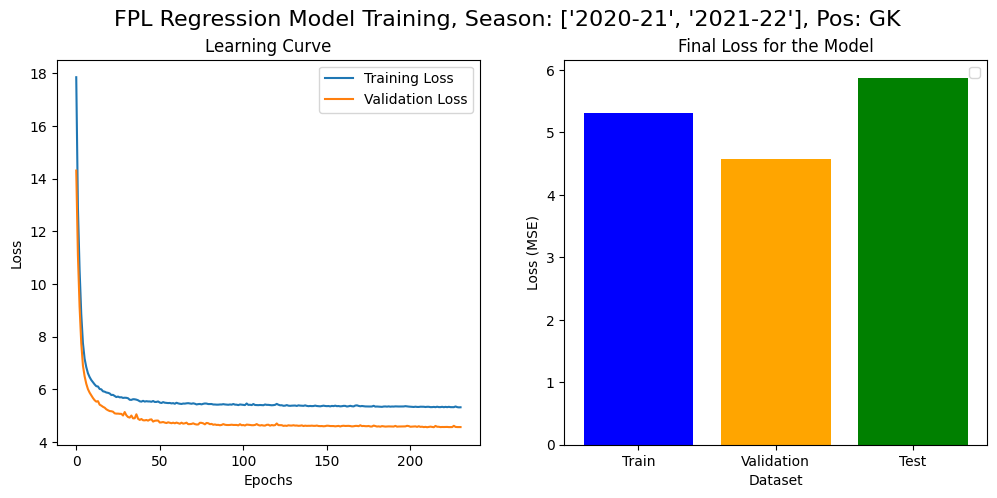

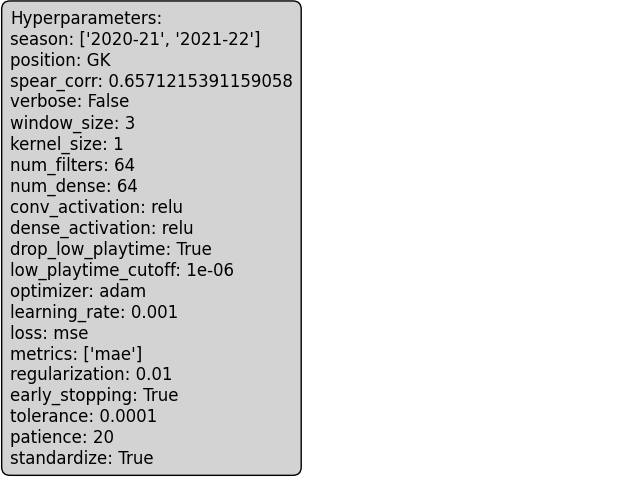

16/16 [==============================] - 0s 402us/step

Worst two examples for GK:



Actual Score  Predicted Score        MSE  d_test  pts_week0  pts_week1  \
326            10         1.222097  77.051576    -2.0          9          0   
92              9         0.332277  75.129429     1.0          0          0   

     pts_week2  
326          0  
92           0


Best two examples for GK:



Actual Score  Predicted Score      MSE  d_test  pts_week0  pts_week1  \
209             3         2.976756  0.00054    -2.0          1         11   
213             3         2.981823  0.00033    -1.0          9         10   

     pts_week2  
209          2  
213          0

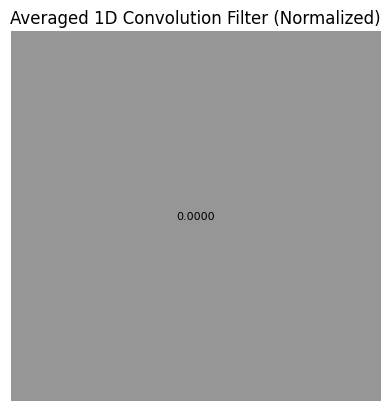


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (5912, 9, 1)
X_val shape: (2560, 9, 1)
X_test shape: (1607, 9, 1)
Epoch 117: early stopping
51/51 [==============================] - 0s 320us/step


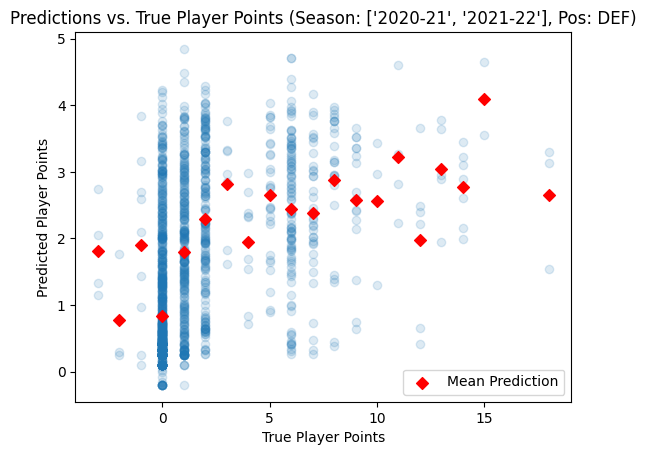

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.964709281921387, Test Mean Absolute Error (MAE): 1.4984160661697388, Test Spearman Correlation: 0.5705504417419434


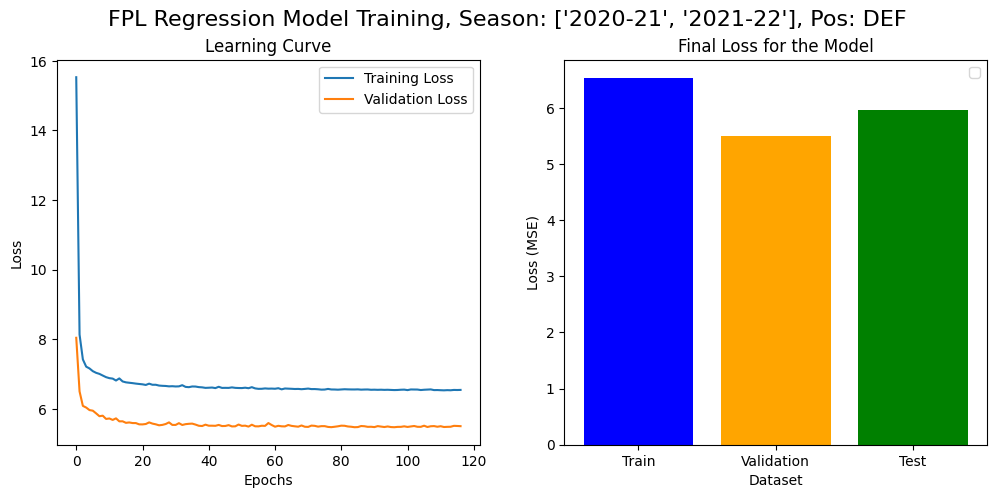

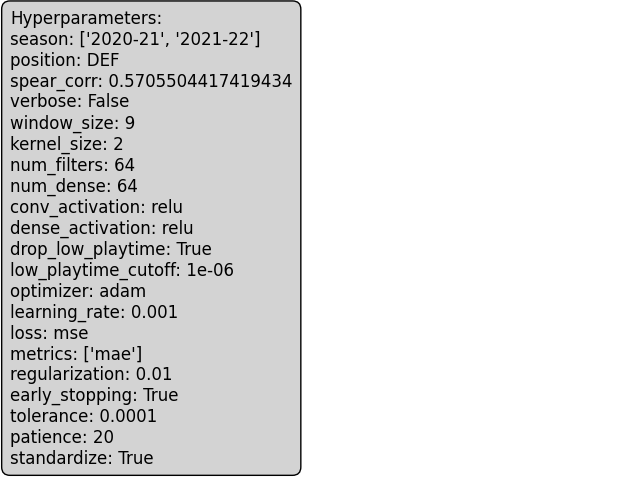

51/51 [==============================] - 0s 324us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1192            18         1.542600  270.846025     2.0          0          1   
933             18         3.139894  220.822743     0.0          1          1   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1192          0          4          1          0          1          1   
933           1          5          3          2          5         14   

      pts_week8  
1192          0  
933          11


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
1070             1         1.006562  0.000043     2.0          6          2   
1043             0        -0.006248  0.000039    -3.0          0          6   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1070          0          0          2          0          1          0   
1043          1          0          0          0          0          0   

      pts_week8  
1070          0  
1043          0

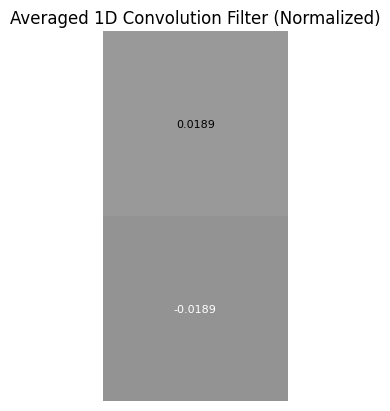


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (6970, 9, 1)
X_val shape: (2905, 9, 1)
X_test shape: (1710, 9, 1)
Epoch 80: early stopping
54/54 [==============================] - 0s 361us/step


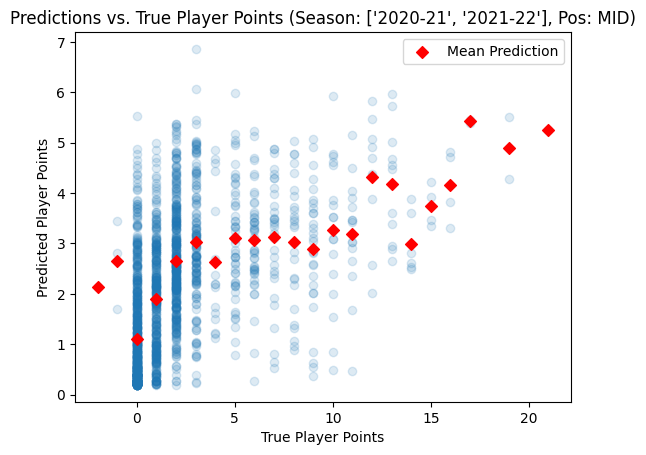

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 7.071574687957764, Test Mean Absolute Error (MAE): 1.6682350635528564, Test Spearman Correlation: 0.6195084452629089


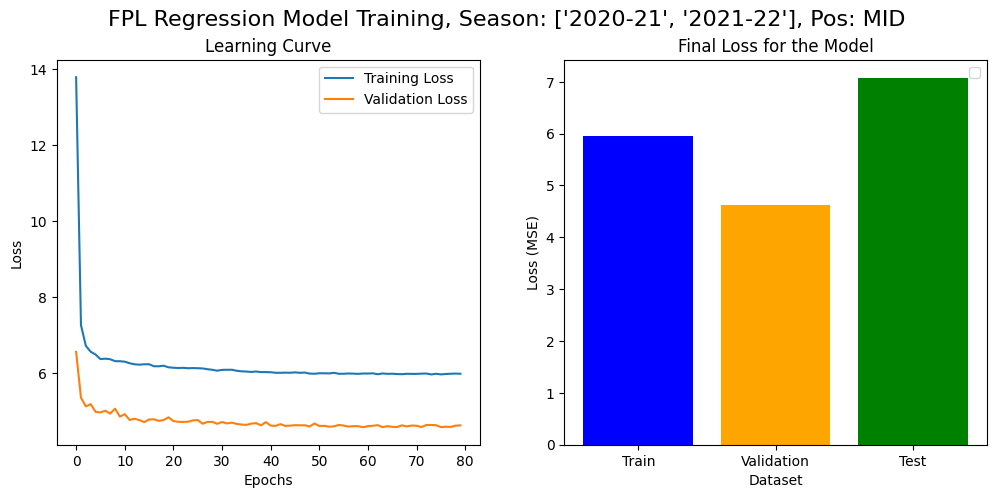

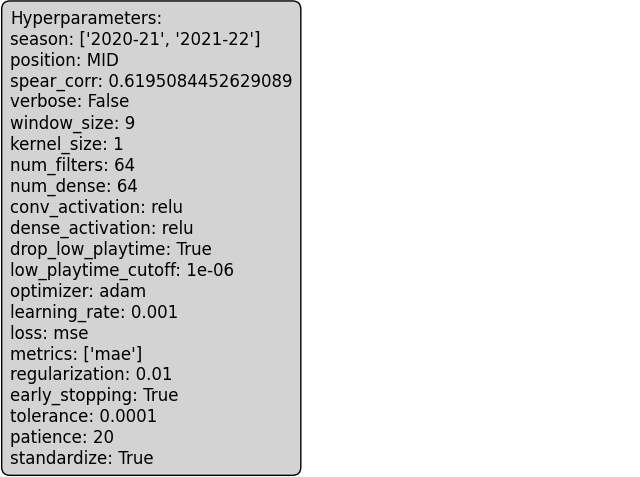

54/54 [==============================] - 0s 363us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1151            21         5.255826  247.879015     2.0          2         10   
1436            19         4.282748  216.597500     3.0          5          2   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1151          2          9          7          2          3         15   
1436          2          6          0          0          0          3   

      pts_week8  
1151         12  
1436          7


Best two examples for MID:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
1407             2         1.991497  0.000072     0.0          1          7   
617              1         1.005846  0.000034     0.0          1          1   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1407          8          6          0          0          0          1   
617           1          0          0          0          1          0   

      pts_week8  
1407          1  
617           1

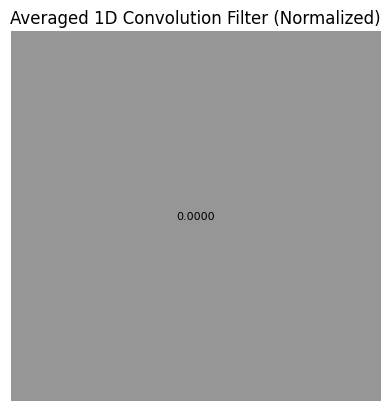


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (1970, 9, 1)
X_val shape: (953, 9, 1)
X_test shape: (467, 9, 1)
Epoch 160: early stopping
15/15 [==============================] - 0s 386us/step


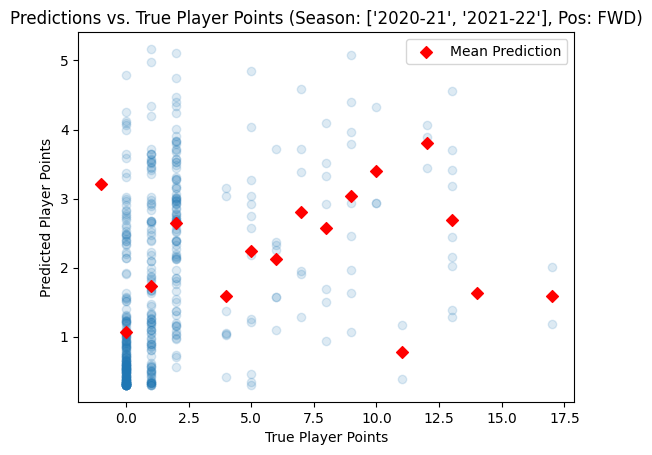

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 8.487678527832031, Test Mean Absolute Error (MAE): 1.7542738914489746, Test Spearman Correlation: 0.5196046829223633


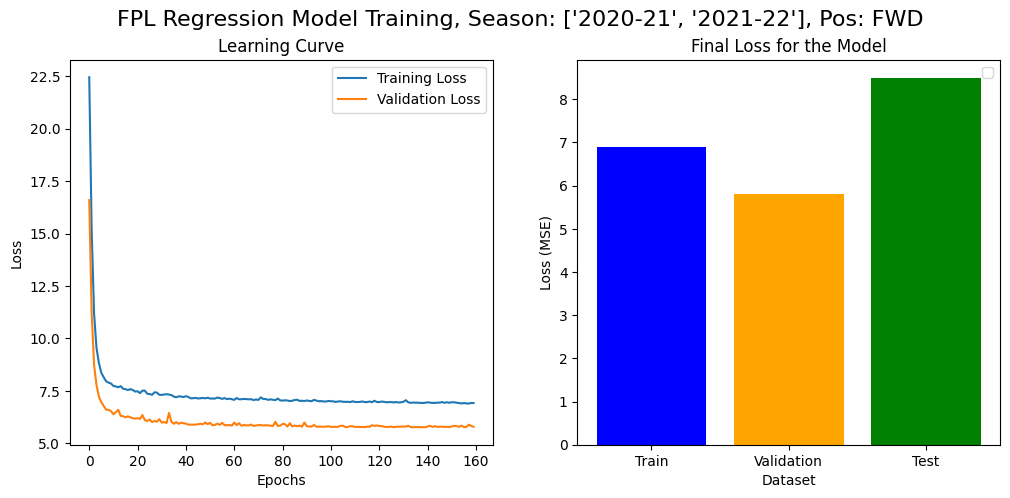

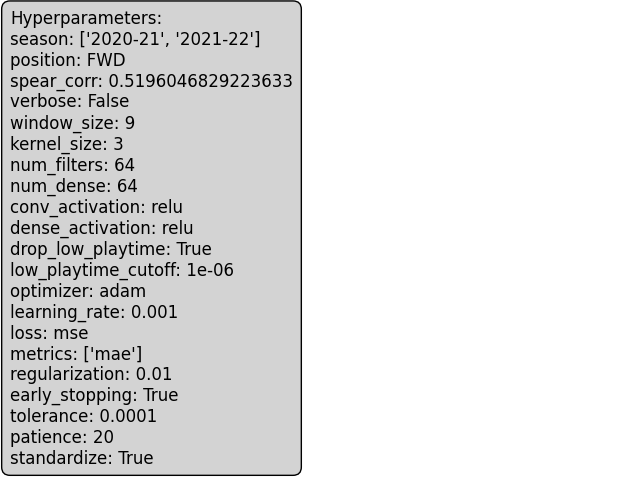

15/15 [==============================] - 0s 394us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
370            17         1.186119  250.078822     0.0          0          2   
373            17         2.006266  224.812056     2.0          1          2   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
370          2          1          2          8          1          2   
373          8          1          2          0         16          0   

     pts_week8  
370          0  
373          1


Best two examples for FWD:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
3               1         0.973901  0.000681    -2.0          0          0   
185             1         0.977282  0.000516     0.0          2          8   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
3            0          0          0          0          1          0   
185          2          1          1          6          2          0   

     pts_week8  
3            1  
185          0

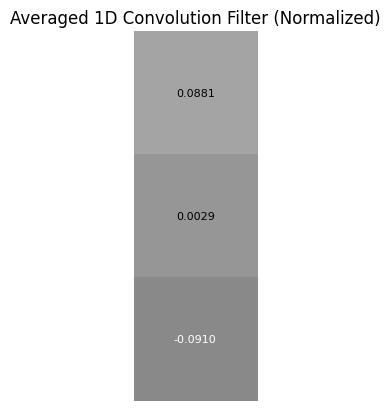

In [ ]:
# model with drop benched players
best_models = investigate_model_v0('gridsearch_v10', drop_low_playtime=True)

## V9

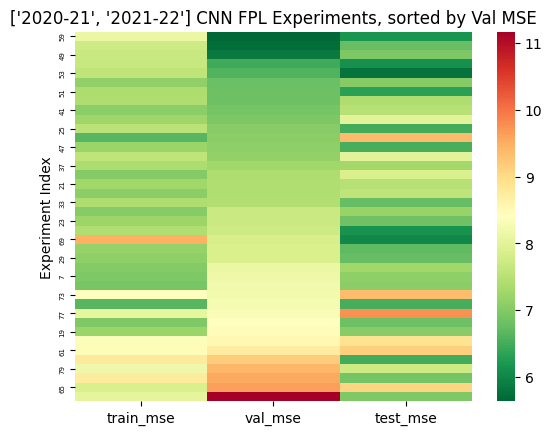


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           4          64   
MID  ['2020-21', '2021-22']      MID           9           4          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff  ... loss  metrics regularization early_stopping  \
GK                   15  ...  mse  ['mae']           0.01           True   
DEF                  15  ...  mse  ['mae']           0.01           True   
MID                  15  ...  mse  ['mae']           0.01           True   
FWD                  15  ...  mse  ['mae']           0.01           True   

    tolerance patience standardize amt_num_features  \
GK     0.0001       20        True          ptsonly   
DEF    0.0001       20        True          ptsonly   
MID    0.0001       20        True          ptsonly   
FWD    0.0001       20        True          ptsonly   

                                               dataset  \
GK   b"\x80\x04\x95\x88\x03\x01\x00\x00\x00\x00\x00...   
DEF  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
MID  b'\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   
FWD  b"\x80\x04\x95\x93\x00\x00\x00\x00\x00\x00\x00...   

                                              pipeline  
GK   b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
DEF  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
MID  b'\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  
FWD  b"\x80\x04\x95\xcf\x05\x00\x00\x00\x00\x00\x00...  

[4 rows x 22 columns]


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    6.638127  7.077146  9.361521   1.872193  1.961152  2.312570
DEF   7.397700  6.810213  7.400216   1.925115  1.804381  1.960462
MID   8.133569  5.633235  6.167350   1.911633  1.575351  1.660699
FWD   9.475021  7.837012  6.022042   2.074050  1.878752  1.719231


Average Val MSE:
6.839401602745056

Average Test MSE:
7.237782001495361

======= Retraining and Filter Analysis for GK model: =======

X_train shape: (828, 9, 1)
X_val shape: (405, 9, 1)
X_test shape: (261, 9, 1)
Epoch 136: early stopping
9/9 [==============================] - 0s 399us/step


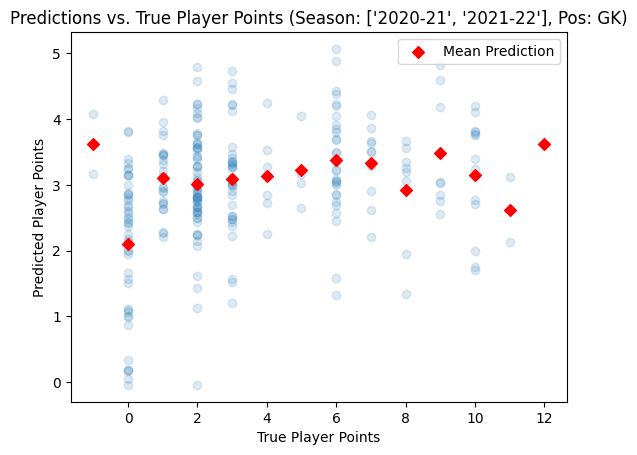

Test Loss (MSE): 9.269883155822754, Test Mean Absolute Error (MAE): 2.30424427986145, Test Spearman Correlation: 0.30566444993019104


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


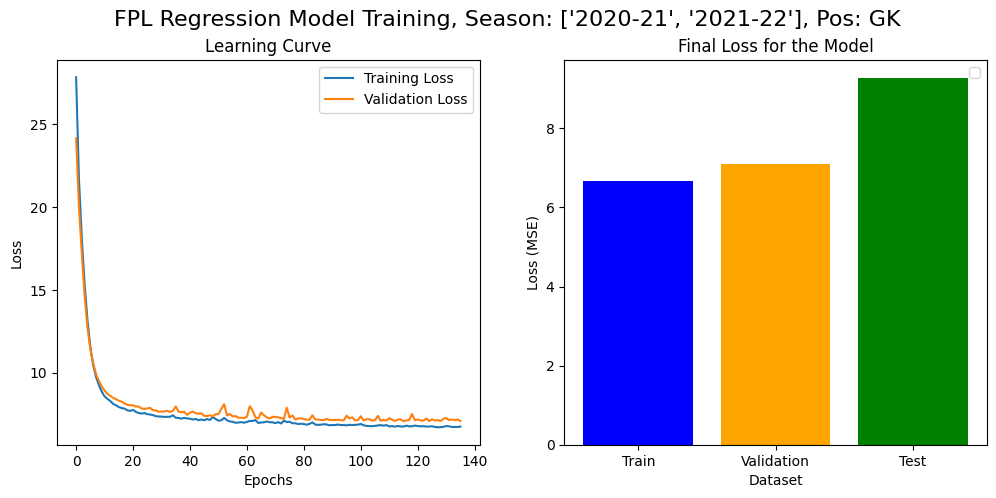

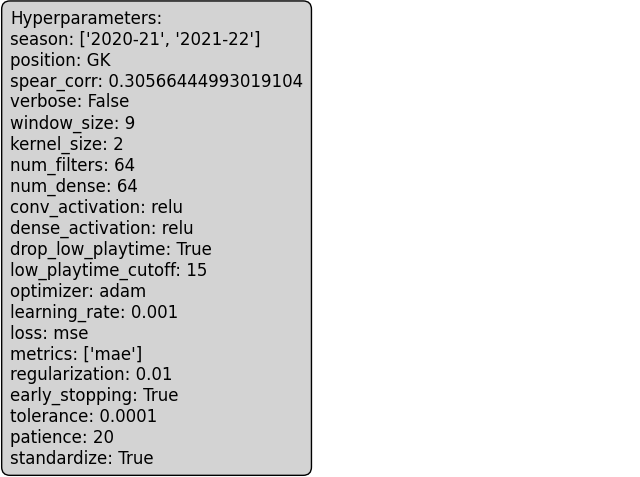

9/9 [==============================] - 0s 535us/step

Worst two examples for GK:



Actual Score  Predicted Score        MSE  d_test  pts_week0  pts_week1  \
233            11         2.127870  78.714698    -2.0          0          0   
41             12         3.620514  70.215783     0.0         10          3   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
233          0          3          3          2          1          1   
41           3          3          6          1         10          4   

     pts_week8  
233          2  
41           9


Best two examples for GK:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
60              3         3.016715  0.000279    -1.0          1          3   
102             3         3.002128  0.000005     0.0          9          7   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
60           3          3          6          4          2          2   
102         10          0          2          8          3          2   

     pts_week8  
60           2  
102          1

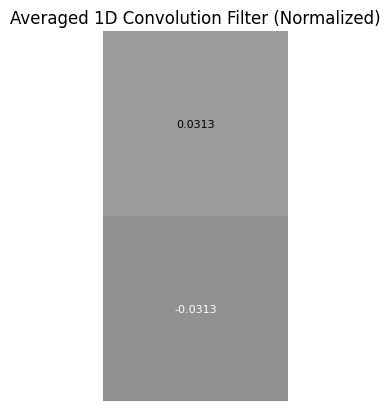


======= Retraining and Filter Analysis for DEF model: =======

X_train shape: (5309, 6, 1)
X_val shape: (2377, 6, 1)
X_test shape: (1328, 6, 1)
Epoch 106: early stopping
42/42 [==============================] - 0s 342us/step


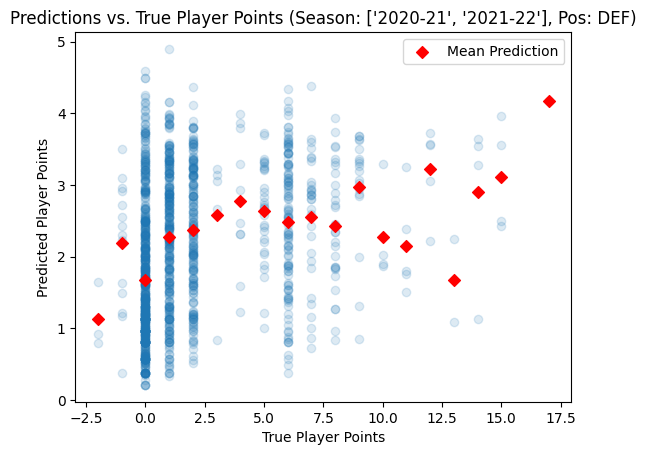

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 7.420467376708984, Test Mean Absolute Error (MAE): 2.0274057388305664, Test Spearman Correlation: 0.3678724765777588


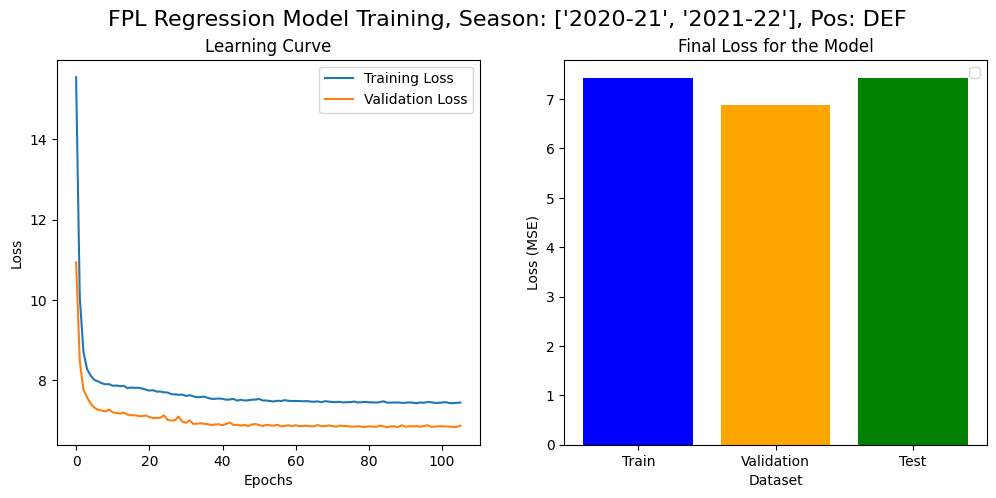

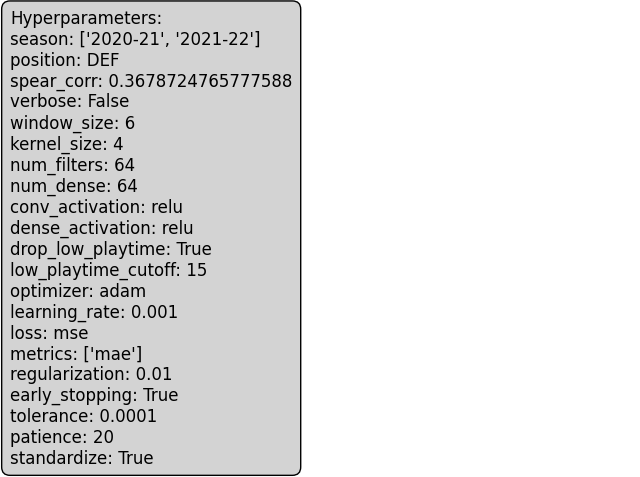

42/42 [==============================] - 0s 325us/step

Worst two examples for DEF:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
302            14         1.132282  165.578178     2.0          0          0   
399            17         4.175469  164.468585     2.0          6          6   

     pts_week2  pts_week3  pts_week4  pts_week5  
302          0          0          0          0  
399          6          2          1          8


Best two examples for DEF:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
400              4         3.989685  0.000106     1.0          6          6   
1312             2         1.992430  0.000057     1.0          0          0   

      pts_week2  pts_week3  pts_week4  pts_week5  
400           2          1          8         17  
1312          0          0          0          1

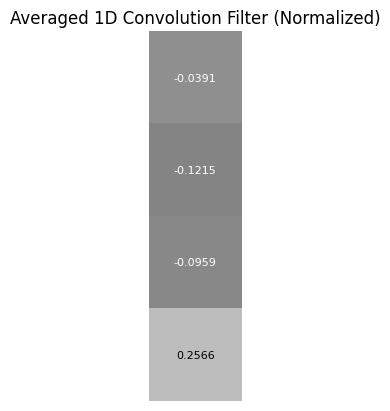


======= Retraining and Filter Analysis for MID model: =======

X_train shape: (5356, 9, 1)
X_val shape: (2222, 9, 1)
X_test shape: (1575, 9, 1)
Epoch 57: early stopping
50/50 [==============================] - 0s 336us/step


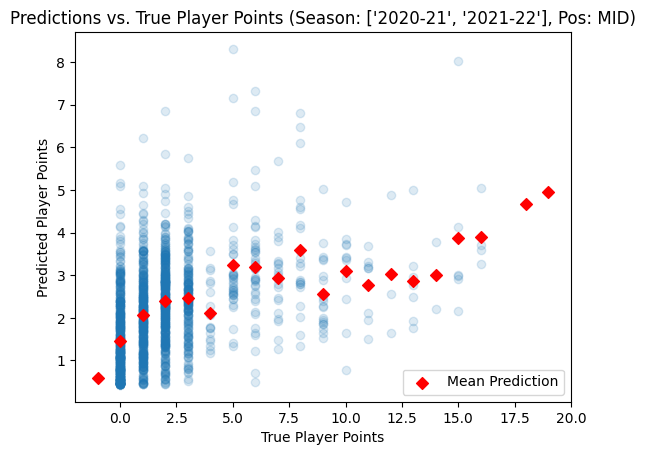

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 5.988887786865234, Test Mean Absolute Error (MAE): 1.579519510269165, Test Spearman Correlation: 0.49070972204208374


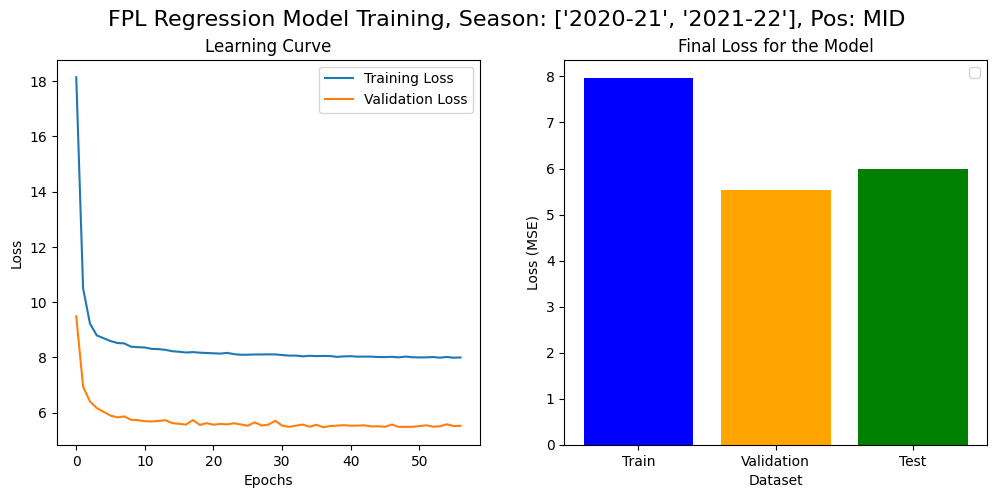

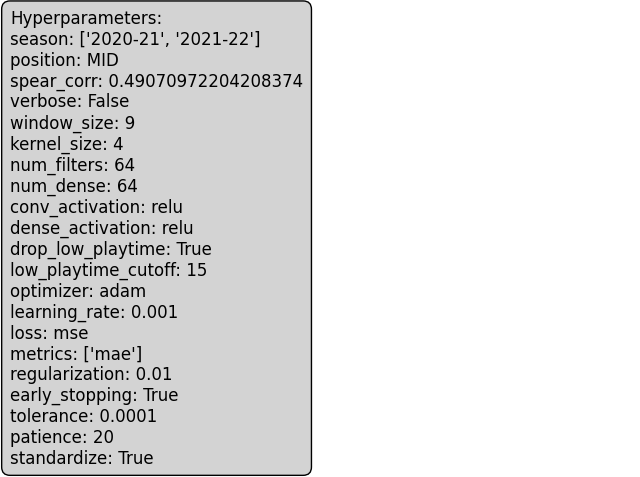

50/50 [==============================] - 0s 341us/step

Worst two examples for MID:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
1481            19         4.940163  197.679026     1.0          1          3   
1475            18         4.674582  177.566777     3.0          8          2   

      pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
1481         10         18          3          9          1          3   
1475          0          7          0          0          1          3   

      pts_week8  
1481          5  
1475         10


Best two examples for MID:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
750             3         3.001474  0.000002     2.0          2          2   
539             1         0.998571  0.000002    -1.0          0          1   

     pts_week2  pts_week3  pts_week4  pts_week5  pts_week6  pts_week7  \
750          0          2          0          3          2          0   
539          1          2          0          0          0          0   

     pts_week8  
750          3  
539          1

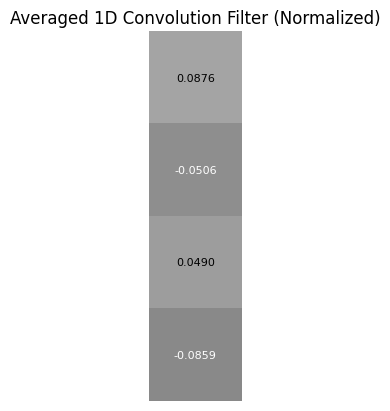


======= Retraining and Filter Analysis for FWD model: =======

X_train shape: (1599, 6, 1)
X_val shape: (856, 6, 1)
X_test shape: (416, 6, 1)
Epoch 128: early stopping
13/13 [==============================] - 0s 389us/step


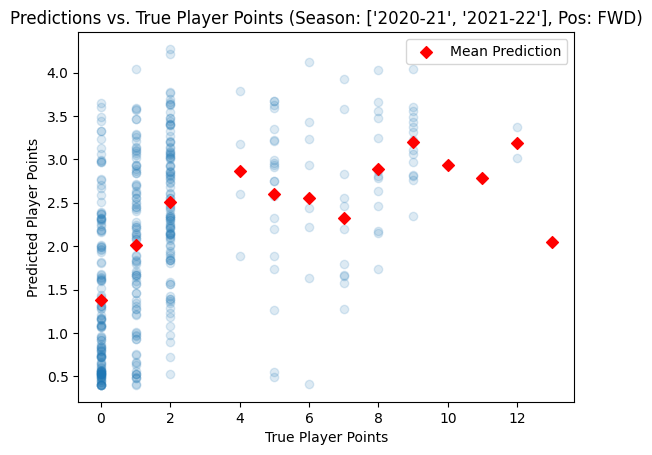

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Test Loss (MSE): 6.038299083709717, Test Mean Absolute Error (MAE): 1.7248278856277466, Test Spearman Correlation: 0.5221307873725891


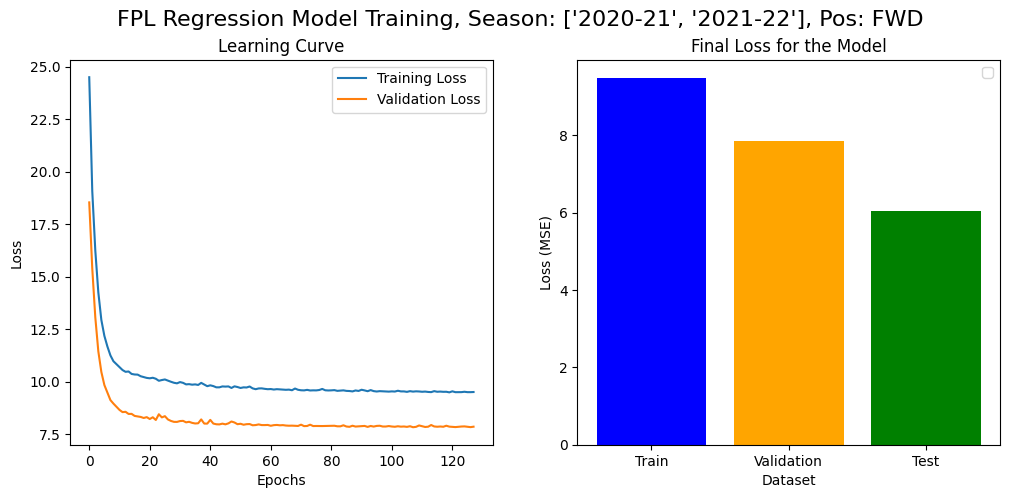

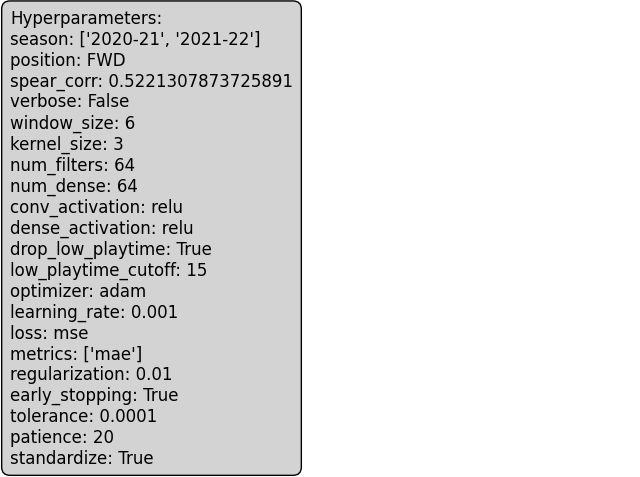

13/13 [==============================] - 0s 409us/step

Worst two examples for FWD:



Actual Score  Predicted Score         MSE  d_test  pts_week0  pts_week1  \
135            13         2.045007  120.011867     0.0          8          9   
6              12         3.012552   80.774221     1.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
135          2          1          1          1  
6            1          1          1          2


Best two examples for FWD:



Actual Score  Predicted Score       MSE  d_test  pts_week0  pts_week1  \
224             1         0.993973  0.000036     0.0          1          0   
375             2         1.997917  0.000004    -3.0          0          0   

     pts_week2  pts_week3  pts_week4  pts_week5  
224          1          1          1          0  
375          0          2          0          2

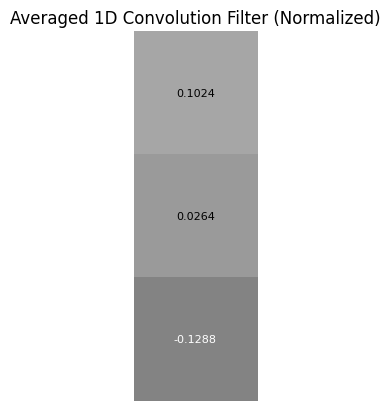

In [ ]:
best_models = investigate_model_v0('gridsearch_v9', drop_low_playtime=True)

## V8

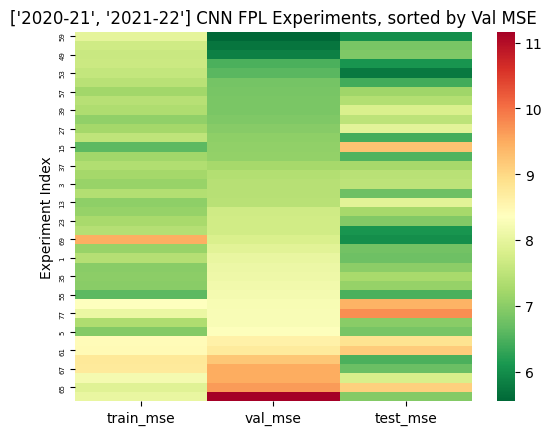


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           4          64   
MID  ['2020-21', '2021-22']      MID           9           4          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam         0.001  mse  ['mae']           0.01   
DEF                  15      adam         0.001  mse  ['mae']           0.01   
MID                  15      adam         0.001  mse  ['mae']           0.01   
FWD                  15      adam         0.001  mse  ['mae']           0.01   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    6.626597  7.062074  9.259813   1.847902  1.944556  2.293070
DEF   7.420223  6.847605  7.392525   1.931955  1.816363  1.964366
MID   7.966120  5.552106  6.002896   1.864414  1.533915  1.608717
FWD   9.465921  7.826174  6.006136   2.080553  1.882488  1.723334


Average Val MSE:
6.8219897747039795

Average Test MSE:
7.165342688560486


In [ ]:
# with player dropping
best_params = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)

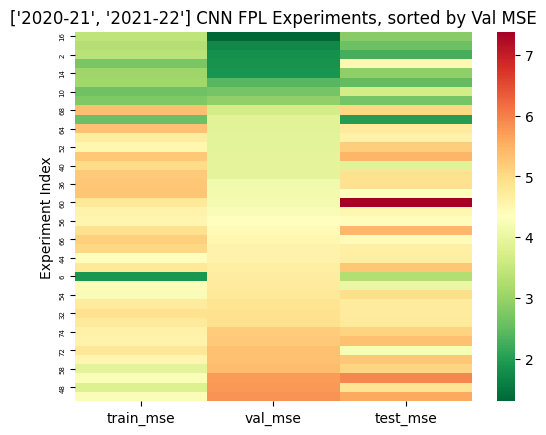


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           3          64   
DEF  ['2020-21', '2021-22']      DEF           6           2          64   
MID  ['2020-21', '2021-22']      MID           6           2          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam         0.001  mse  ['mae']           0.01   
DEF                  15      adam         0.001  mse  ['mae']           0.01   
MID                  15      adam         0.001  mse  ['mae']           0.01   
FWD                  15      adam         0.001  mse  ['mae']           0.01   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.435112  1.303213  2.849222   0.950505  0.394232  0.795444
DEF   5.198655  3.936277  4.891015   1.377866  1.160604  1.338731
MID   4.715411  3.896753  4.615019   1.201099  1.121303  1.225162
FWD   5.340059  3.686617  5.037661   1.301746  0.963543  1.250446


Average Val MSE:
3.205714911222458

Average Test MSE:
4.3482290506362915


In [ ]:
# with player dropping
best_hyperparams = gridsearch_analysis('gridsearch_v8', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)

## V7


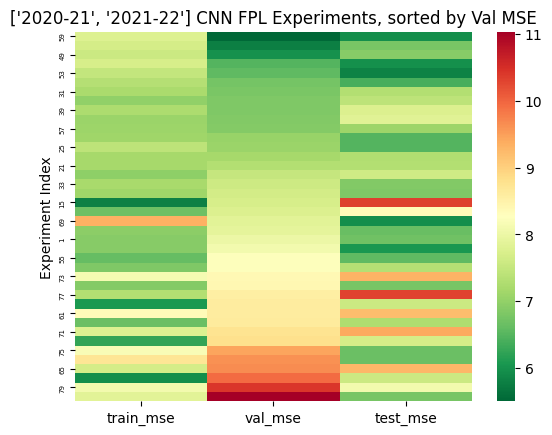


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           4          64   
MID  ['2020-21', '2021-22']      MID           9           4          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    6.965347  7.507768  7.612298   1.900025  1.981733  2.132873
DEF   7.218315  6.797379  7.304734   1.943144  1.854269  1.990746
MID   7.793943  5.503473  5.951376   1.802677  1.505303  1.566666
FWD   9.333324  7.843918  5.936503   2.187824  2.002839  1.837570


Average Val MSE:
6.913134336471558

Average Test MSE:
6.701227784156799


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           4          64   
MID  ['2020-21', '2021-22']      MID           9           4          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly

In [ ]:
# with player dropping
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = True)

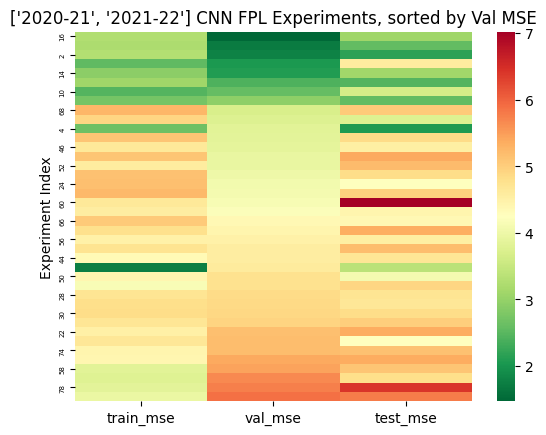


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           3          64   
DEF  ['2020-21', '2021-22']      DEF           6           2          64   
MID  ['2020-21', '2021-22']      MID           3           1          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.264033  1.472767  3.087075   1.099921  0.677386  0.996329
DEF   5.114088  3.853492  4.844957   1.296149  1.070396  1.257257
MID   4.917191  3.763637  3.768542   1.197166  1.040040  1.048474
FWD   5.261523  3.700449  5.041334   1.320371  1.041827  1.281191


Average Val MSE:
3.1975861489772797

Average Test MSE:
4.185477018356323


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           3          64   
DEF  ['2020-21', '2021-22']      DEF           6           2          64   
MID  ['2020-21', '2021-22']      MID           3           1          64   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu             False   
DEF        64            relu             relu             False   
MID        64            relu             relu             False   
FWD        64            relu             relu             False   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly

In [ ]:
# without player dropping
gridsearch_analysis('gridsearch_v7', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    drop_low_playtime = False)

## V6  With Player Dropping

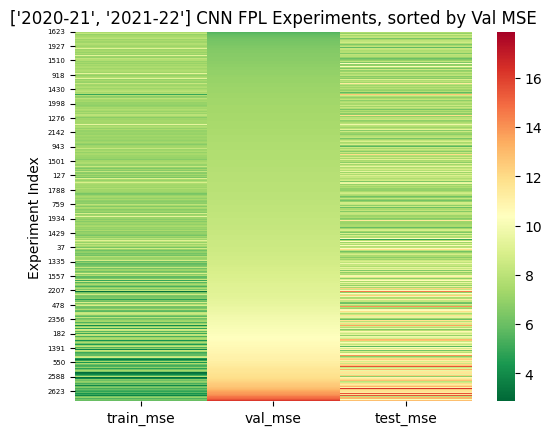


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 5 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK         3.0         1.0          64   
DEF  ['2020-21', '2021-22']      DEF           3           1          64   
MID  ['2020-21', '2021-22']      MID         3.0         2.0       128.0   
FWD  ['2020-21', '2021-22']      FWD         3.0         1.0         128   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK       64.0            relu             relu              True   
DEF      64.0            relu             relu              True   
MID        64            relu             relu              True   
FWD       128            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                 15.0      adam          0.01  mse  ['mae']          0.001   
DEF                15.0      adam          0.01  mse  ['mae']          0.001   
MID                15.0      adam          0.01  mse  ['mae']          0.001   
FWD                15.0      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001     20.0        True          ptsonly  
DEF           True    0.0001     20.0        True            large  
MID           True    0.0001     20.0        True           medium  
FWD           True    0.0001     20.0        True           medium


['2020-21', '2021-22'] Mean Performance of Top 5 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    7.763064  5.973737  7.543674   2.178129  1.874671  2.162254
DEF   7.880770  6.345948  7.368134   1.996224  1.808207  1.976262
MID   7.726225  5.334068  7.786359   1.790821  1.513833  1.814316
FWD   9.595366  6.183167  8.353703   2.124862  1.758133  1.998138


Average Val MSE:
5.959229826927186

Average Test MSE:
7.762967610359192


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK         3.0         1.0          64   
DEF  ['2020-21', '2021-22']      DEF           3           1          64   
MID  ['2020-21', '2021-22']      MID         3.0         2.0       128.0   
FWD  ['2020-21', '2021-22']      FWD         3.0         1.0         128   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK       64.0            relu             relu              True   
DEF      64.0            relu             relu              True   
MID        64            relu             relu              True   
FWD       128            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                 15.0      adam          0.01  mse  ['mae']          0.001   
DEF                15.0      adam          0.01  mse  ['mae']          0.001   
MID                15.0      adam          0.01  mse  ['mae']          0.001   
FWD                15.0      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001     20.0        True          ptsonly  
DEF           True    0.0001     20.0        True            large  
MID           True    0.0001     20.0        True           medium  
FWD           True    0.0001     20.0        True           medium

In [ ]:
gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=5,
                    drop_low_playtime = True)

## V6 Best Models Without Player Dropping

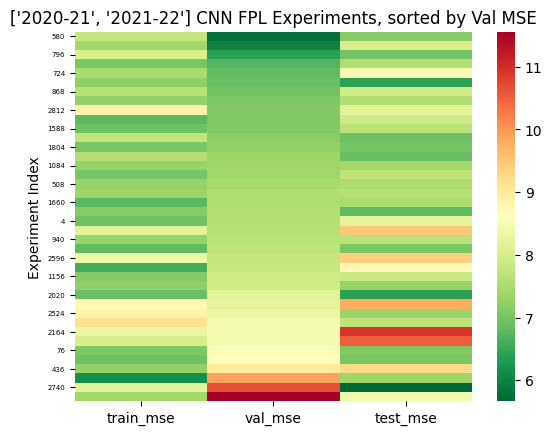


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           3          64   
DEF  ['2020-21', '2021-22']      DEF           3           2          64   
MID  ['2020-21', '2021-22']      MID           3           2          64   
FWD  ['2020-21', '2021-22']      FWD           9           4          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    7.799668  5.780939  7.159147   2.183910  1.916537  2.131874
DEF   8.038533  6.400522  6.971214   2.023532  1.793616  1.951067
MID   7.413644  5.994377  8.014818   1.758009  1.618264  1.835909
FWD   8.829316  7.094800  8.160402   1.961530  1.816394  1.911481


Average Val MSE:
6.317659378051758

Average Test MSE:
7.576395392417908


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           9           3          64   
DEF  ['2020-21', '2021-22']      DEF           3           2          64   
MID  ['2020-21', '2021-22']      MID           3           2          64   
FWD  ['2020-21', '2021-22']      FWD           9           4          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize amt_num_features  
GK            True    0.0001       20        True          ptsonly  
DEF           True    0.0001       20        True          ptsonly  
MID           True    0.0001       20        True          ptsonly  
FWD           True    0.0001       20        True          ptsonly

In [ ]:
gridsearch_analysis('gridsearch_v6', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1,
                    num_dense=64,
                    num_filters=64,
                    amt_num_features = 'ptsonly',
                    drop_low_playtime = True)

## Other Models

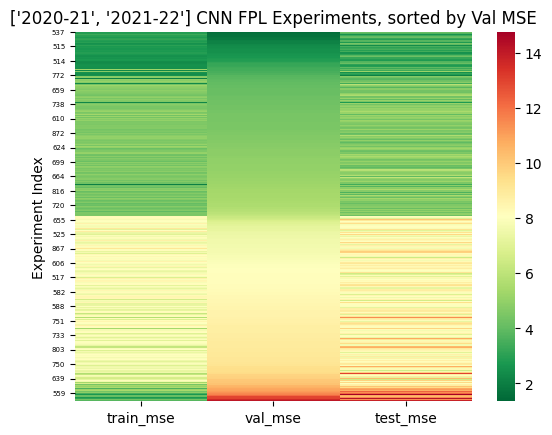


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           1          64   
MID  ['2020-21', '2021-22']      MID           9           3          64   
FWD  ['2020-21', '2021-22']      FWD           6           2          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                    0      adam          0.01  mse  ['mae']          0.001   
DEF                   0      adam          0.01  mse  ['mae']          0.001   
MID                   0      adam          0.01  mse  ['mae']          0.001   
FWD                   0      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize  
GK            True   0.00001       20        True  
DEF           True   0.00001       20        True  
MID           True   0.00001       20        True  
FWD           True   0.00001       20        True


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    3.017067  1.354558  3.231826   0.943844  0.480153  0.878352
DEF   5.195624  4.065986  4.967775   1.309599  1.095808  1.234611
MID   5.203198  3.418591  4.020970   1.364603  1.116390  1.216766
FWD   5.022539  3.957532  4.335554   1.269606  1.154236  1.179623


Average Val MSE:
3.1991667449474335

Average Test MSE:
4.139031410217285


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           6           2          64   
DEF  ['2020-21', '2021-22']      DEF           6           1          64   
MID  ['2020-21', '2021-22']      MID           9           3          64   
FWD  ['2020-21', '2021-22']      FWD           6           2          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID        64            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                    0      adam          0.01  mse  ['mae']          0.001   
DEF                   0      adam          0.01  mse  ['mae']          0.001   
MID                   0      adam          0.01  mse  ['mae']          0.001   
FWD                   0      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize  
GK            True   0.00001       20        True  
DEF           True   0.00001       20        True  
MID           True   0.00001       20        True  
FWD           True   0.00001       20        True

In [ ]:
gridsearch_analysis('_gridsearch_v4', 
                    season="['2020-21', '2021-22']", 
                    eval_top=1)

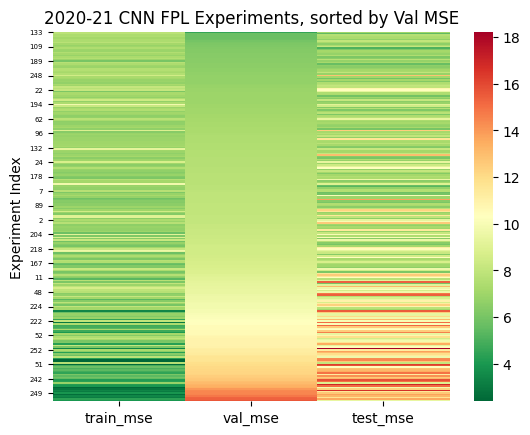


2020-21 Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters num_dense  \
GK   2020-21       GK           3           2         128       128   
DEF  2020-21      DEF           3           2         128        64   
MID  2020-21      MID           3           1         128        64   
FWD  2020-21      FWD           9           3          64        64   

    conv_activation dense_activation drop_low_playtime low_playtime_cutoff  \
GK             relu             relu              True                  15   
DEF            relu             relu              True                  15   
MID            relu             relu              True                  15   
FWD            relu             relu              True                  15   

    optimizer learning_rate loss  metrics regularization early_stopping  \
GK       adam          0.01  mse  ['mae']          0.001           True   
DEF      adam          0.01  mse  ['mae']          0.001           True   
MID      adam          0.01  mse  ['mae']          0.001           True   
FWD      adam          0.01  mse  ['mae']          0.001           True   

    tolerance patience standardize  
GK     0.0001       20        True  
DEF    0.0001       20        True  
MID    0.0001       20        True  
FWD    0.0001       20        True


2020-21 Mean Performance of Top 1 Model by Position


train_mse   val_mse   test_mse  train_mae   val_mae  test_mae
GK    8.141123  6.824385   7.916274   2.188909  2.047065  2.124977
DEF   7.361140  5.961607   7.985064   1.923399  1.701088  1.955373
MID   7.806750  4.545766   7.036894   1.781249  1.412960  1.573859
FWD   8.474202  6.671063  12.801478   1.837902  1.502172  2.085198


Average Val MSE:
6.000705361366272

Average Test MSE:
8.934927344322205


season position window_size kernel_size num_filters num_dense  \
GK   2020-21       GK           3           2         128       128   
DEF  2020-21      DEF           3           2         128        64   
MID  2020-21      MID           3           1         128        64   
FWD  2020-21      FWD           9           3          64        64   

    conv_activation dense_activation drop_low_playtime low_playtime_cutoff  \
GK             relu             relu              True                  15   
DEF            relu             relu              True                  15   
MID            relu             relu              True                  15   
FWD            relu             relu              True                  15   

    optimizer learning_rate loss  metrics regularization early_stopping  \
GK       adam          0.01  mse  ['mae']          0.001           True   
DEF      adam          0.01  mse  ['mae']          0.001           True   
MID      adam          0.01  mse  ['mae']          0.001           True   
FWD      adam          0.01  mse  ['mae']          0.001           True   

    tolerance patience standardize  
GK     0.0001       20        True  
DEF    0.0001       20        True  
MID    0.0001       20        True  
FWD    0.0001       20        True

In [ ]:
gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2020-21',
                    eval_top=1)

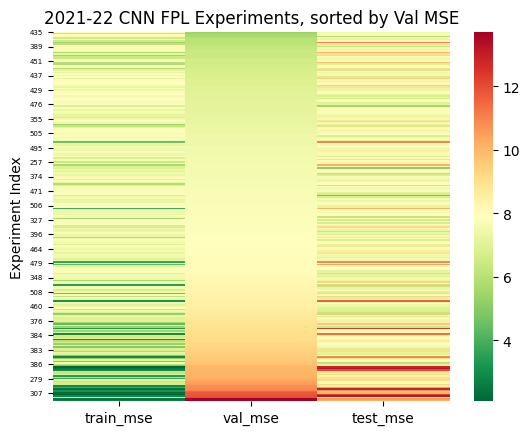


2021-22 Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters num_dense  \
GK   2021-22       GK           3           1          64       128   
DEF  2021-22      DEF           3           1          64       128   
MID  2021-22      MID           9           2          64       128   
FWD  2021-22      FWD           3           2         128       128   

    conv_activation dense_activation drop_low_playtime low_playtime_cutoff  \
GK             relu             relu              True                  15   
DEF            relu             relu              True                  15   
MID            relu             relu              True                  15   
FWD            relu             relu              True                  15   

    optimizer learning_rate loss  metrics regularization early_stopping  \
GK       adam          0.01  mse  ['mae']          0.001           True   
DEF      adam          0.01  mse  ['mae']          0.001           True   
MID      adam          0.01  mse  ['mae']          0.001           True   
FWD      adam          0.01  mse  ['mae']          0.001           True   

    tolerance patience standardize  
GK     0.0001       20        True  
DEF    0.0001       20        True  
MID    0.0001       20        True  
FWD    0.0001       20        True


2021-22 Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    6.282449  5.409356  7.727600   1.978861  1.745968  2.250708
DEF   8.258613  6.538323  7.482368   2.009390  1.755708  1.877538
MID   7.688234  5.407370  7.526227   1.705003  1.390600  1.668036
FWD   8.200192  6.277791  7.468069   1.857814  1.615428  1.758949


Average Val MSE:
5.908209919929504

Average Test MSE:
7.551065683364868


season position window_size kernel_size num_filters num_dense  \
GK   2021-22       GK           3           1          64       128   
DEF  2021-22      DEF           3           1          64       128   
MID  2021-22      MID           9           2          64       128   
FWD  2021-22      FWD           3           2         128       128   

    conv_activation dense_activation drop_low_playtime low_playtime_cutoff  \
GK             relu             relu              True                  15   
DEF            relu             relu              True                  15   
MID            relu             relu              True                  15   
FWD            relu             relu              True                  15   

    optimizer learning_rate loss  metrics regularization early_stopping  \
GK       adam          0.01  mse  ['mae']          0.001           True   
DEF      adam          0.01  mse  ['mae']          0.001           True   
MID      adam          0.01  mse  ['mae']          0.001           True   
FWD      adam          0.01  mse  ['mae']          0.001           True   

    tolerance patience standardize  
GK     0.0001       20        True  
DEF    0.0001       20        True  
MID    0.0001       20        True  
FWD    0.0001       20        True

In [ ]:
gridsearch_analysis('gridsearch_v4_singleyear_drop', 
                    season='2021-22',
                    eval_top=1)

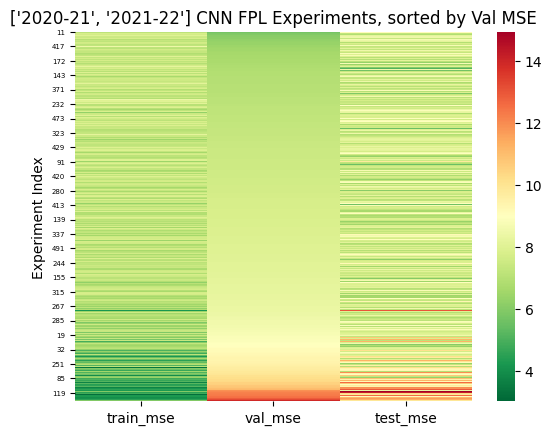


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 3 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1         128   
DEF  ['2020-21', '2021-22']      DEF           6           2         128   
MID  ['2020-21', '2021-22']      MID           3         2.0        64.0   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID     128.0            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                15.0      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize  
GK            True    0.0001       20        True  
DEF           True    0.0001       20        True  
MID           True    0.0001     20.0        True  
FWD           True    0.0001       20        True


['2020-21', '2021-22'] Mean Performance of Top 3 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    7.726385  5.961474  7.941252   2.130761  1.823522  2.112105
DEF   7.698494  6.388040  7.966989   1.968146  1.798182  2.000433
MID   7.488968  5.829319  8.056349   1.718086  1.524288  1.786029
FWD   8.242097  6.646223  7.732026   1.930773  1.760133  1.893312


Average Val MSE:
6.2062638600667315

Average Test MSE:
7.924153963724772


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1         128   
DEF  ['2020-21', '2021-22']      DEF           6           2         128   
MID  ['2020-21', '2021-22']      MID           3         2.0        64.0   
FWD  ['2020-21', '2021-22']      FWD           6           3          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID     128.0            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                15.0      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize  
GK            True    0.0001       20        True  
DEF           True    0.0001       20        True  
MID           True    0.0001     20.0        True  
FWD           True    0.0001       20        True

In [ ]:
gridsearch_analysis('gridsearch_v5', eval_top=3)

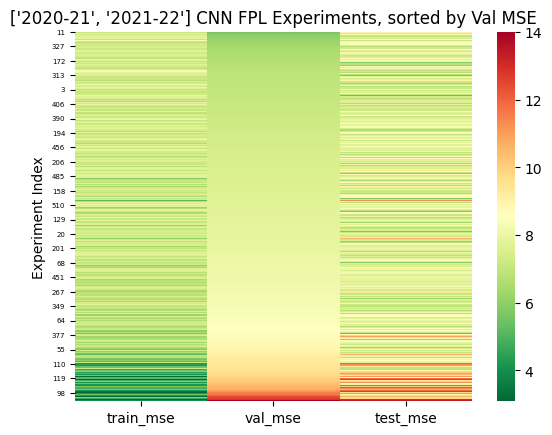


['2020-21', '2021-22'] Mode Best Hyperparameters for Each Position
Via Top 1 Models by Position


season position window_size kernel_size num_filters  \
GK   ['2020-21', '2021-22']       GK           3           1         128   
DEF  ['2020-21', '2021-22']      DEF           3           1         128   
MID  ['2020-21', '2021-22']      MID           6           2          64   
FWD  ['2020-21', '2021-22']      FWD           6           1          64   

    num_dense conv_activation dense_activation drop_low_playtime  \
GK         64            relu             relu              True   
DEF        64            relu             relu              True   
MID       128            relu             relu              True   
FWD        64            relu             relu              True   

    low_playtime_cutoff optimizer learning_rate loss  metrics regularization  \
GK                   15      adam          0.01  mse  ['mae']          0.001   
DEF                  15      adam          0.01  mse  ['mae']          0.001   
MID                  15      adam          0.01  mse  ['mae']          0.001   
FWD                  15      adam          0.01  mse  ['mae']          0.001   

    early_stopping tolerance patience standardize  
GK            True    0.0001       20        True  
DEF           True    0.0001       20        True  
MID           True    0.0001       20        True  
FWD           True    0.0001       20        True


['2020-21', '2021-22'] Mean Performance of Top 1 Model by Position


train_mse   val_mse  test_mse  train_mae   val_mae  test_mae
GK    7.776814  5.582450  7.750151   2.128846  1.722075  2.071969
DEF   7.976913  6.024108  8.130019   2.114493  1.864152  2.111178
MID   7.096155  5.641898  8.965348   1.744442  1.541904  1.920117
FWD   8.390717  6.224425  7.164237   1.914055  1.719082  1.800320


Average Val MSE:
5.868220329284668

Average Test MSE:
8.00243878364563


In [ ]:
best_hyperparams = gridsearch_analysis('gridsearch_v4_optimal_drop', 
                    eval_top=1)